# Libraries and imports

In [2]:
import zipfile
import os
from os import error, walk


from bs4 import BeautifulSoup
import re

from IPython.display import Image as Image_display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# matplotlib.rcParams['figure.dpi'] = 200

%matplotlib inline

from urllib.parse import unquote

import cv2
import pytesseract

from PIL import Image

import json
import io
import numpy as np
import sys
import math
import pickle
from tqdm import tqdm
# Mention the installed location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = "/home/laxman/pdf2charinfo/htmleditor/relevant_text_extraction-main/mtp2code/tesseract-ocr-w64-setup-v5.0.0.20211201.exe"

from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# !pip install opencv-python
# !pip list


# Intializing Sentence Trasnformers

In [3]:
# !pip install pytesseract
# !pip install --upgrade pip

In [4]:

from sentence_transformers import SentenceTransformer
sentence_transformer_model = SentenceTransformer('bert-base-nli-mean-tokens')
sentence_transformer_model_nondebug_dict={}
sentence_transformer_names_nondebug_list = ['sentence-transformers/all-mpnet-base-v2','sentence-transformers/multi-qa-MiniLM-L6-cos-v1','sentence-transformers/all-MiniLM-L6-v2','sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2','sentence-transformers/bert-base-nli-mean-tokens']
for transformer in sentence_transformer_names_nondebug_list:
    sentence_transformer_model_nondebug_dict[transformer] = SentenceTransformer(transformer)

sentence_transformer_model_debug_dict = {}
sentence_transformer_names_debug_list = ['sentence-transformers/all-MiniLM-L6-v2']
sentence_transformer_model_debug_dict['sentence-transformers/all-MiniLM-L6-v2'] = sentence_transformer_model_nondebug_dict['sentence-transformers/all-MiniLM-L6-v2']





/home/laxman/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/home/laxman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance:

In [5]:
# !pip install transformers

In [6]:
# !pip install transformers

# summarizer 

In [7]:
from transformers import pipeline

pipeline_summarizer = pipeline("summarization")


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


# Utilities

In [8]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

def clean_string(txt):
    return remove_non_ascii(txt).replace("Fig. ", "Figure ").replace("fig. ","Figure ")

def extract_lastfig(txt):
    txt = remove_non_ascii(txt).strip().replace("\n"," ")
    last_index = [_.start() for _ in re.finditer(r"Fig", txt)][-1]
    return txt[last_index:]

def get_image_path(html_path,img_src): # get image path from (html path) and (image path in html file) @textbooks
    oebps_path = html_path.split("/Text/")[0]
    img_src = img_src[2:]
    return unquote(oebps_path+img_src)

def get_image_path_papers(html_path, img_src):# get image path from (html path) and (image path in html file) @papers
    acmbooks_path = html_path.split("/OEBPS/")[0]
    img_src = img_src[3:]
    return unquote(acmbooks_path + "/OEBPS/" + img_src)

def convert_trans_to_white_bg(trans_image_path): # change background from transparent to white background
    im_test = Image.open(trans_image_path)

    fill_color = (255,255,255)  # white background color

    im_test = im_test.convert("RGBA")   # it had mode P after DL it from OP
    if im_test.mode in ('RGBA', 'LA'):
        background = Image.new(im_test.mode[:-1], im_test.size, fill_color)
        background.paste(im_test, im_test.split()[-1]) # omit transparency
        im_test = background
    white_image_path = trans_image_path[:-4] + "_white.png"
    im_test.convert("RGB").save(white_image_path)
    return white_image_path


def remove_multi_newlines(text):
    text_list = text.split("\n")
    clean_text_list  = []
    for sent in text_list:
        if len(sent) != 0:
            clean_text_list.append(sent)
    return '\n'.join(clean_text_list)
    
def split_text_to_sent(text):
    text_clean = clean_string(text)
    all_sent_list = re.split('\. |\? |\?|\n',text_clean)
    clean_all_sent_list = []

    for sent in all_sent_list:
        if len(remove_non_ascii(sent).replace(" ","")) > 3:
            clean_all_sent_list.append(sent)

    all_sent_list = clean_all_sent_list
    return all_sent_list

def moving_average(x, w):
    if w == 100:
        pad_x = x.tolist() + [0,0,0,0,0,0,0,0]
        return np.array([max(pad_x[i:i+9]) for i in range(0,len(x))])                    
    elif w == 101:
        pad_x = x.tolist() + [0,0,0,0,0,0,0,0,0,0,0,0]
        return np.array([max(pad_x[i:i+13]) for i in range(0,len(x))])                    
    elif w > 0:
        pad_len = int(w/2)
        pad_x = np.pad(np.array(x), (pad_len, pad_len), 'mean')
        return np.convolve(pad_x, np.ones(w), 'valid') / w
    elif w < 0:
        w = -1*w
        pad_len = int((3*w)/2)
        pad_x = np.pad(np.array(x), (pad_len, pad_len), 'mean')
        sigma=w/2.0
        w = 3*w
        fil  = np.arange(-(w-1)/2,w/2,1)
        assert(len(fil)==w)
        fil = np.exp(-fil**2/(2*sigma**2))
        fil = fil/np.sum(fil)
        # print("len of filter = ",str(w))
        return np.convolve(pad_x, fil, 'valid')

def extract_caption(fig, min_caption_words, max_caption_words):
    caption_parent_text = extract_lastfig(fig.parent.parent.get_text())
    caption_grandparent_text = extract_lastfig(fig.parent.parent.parent.get_text())
    fig_text = extract_lastfig(fig)
    fig_caption = ""
    if len(fig_text.split()) >= max_caption_words:
        return fig_caption
    elif len(fig_text.split()) >= min_caption_words:
        # print(f"fig\nlength = {len(fig.split())}")
        print("fig")
        fig_caption = fig_text
    elif len(caption_parent_text.split()) >= max_caption_words:
        # print(f"fig\nlength = {len(fig.split())}")
        print("fig")
        fig_caption = fig_text
    elif len(caption_grandparent_text.split()) >= max_caption_words:
        # print(f" fig + parent\n length = {len(caption_parent_text.split())}")
        print("fig + parent")
        fig_caption = caption_parent_text
    else:
        # print( f"fig + grandparent \nlength = {len(caption_grandparent_text.split())}")
        print("fig + grandparent")
        fig_caption = caption_grandparent_text
    return fig_caption

def extract_imagepath(fig, filename, type_html):
    same_el_img = fig.parent.find_all("img")
    prev_img = fig.parent.find_previous("img")
    image_path = ""
    if same_el_img == []:
        if prev_img == None:
            print("No image found")
        else:
            if type_html == "textbooks":
                image_path = get_image_path(filename,prev_img["src"])
            if type_html == "papers":
                image_path = get_image_path_papers(filename,prev_img["src"])
            # image_path = convert_trans_to_white_bg(image_path)
            print("previous image = "+ image_path)
    else:
        if type_html == "textbooks":
            image_path = get_image_path(filename,same_el_img[-1]["src"])
        if type_html == "papers":
            image_path = get_image_path_papers(filename,same_el_img[-1]["src"])
        # image_path = convert_trans_to_white_bg(image_path)
        print("same tag image = "+ image_path)
    return image_path

def smooth_label(smooth_no):
#     x = 9
#     y = 10
#     z = sum(x+y)
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"


# Extracting Epub files to folders

In [9]:
# Converting Epub books to folders containing HTML

# folder path of epub books you want to extract images from
epub_folder = "./data/e_pathshala_epub_debug/"
epub_folder_list = ["./data/e_pathshala_epub_debug/", "./data/technical_papers"]

for epub_folder in epub_folder_list:
    for root, dirs, files in os.walk(epub_folder):
        for file in files:
            if file.endswith(".epub"):
                folder_name = root+"/"+file[:-5]
                file_name = root+"/"+file
                # print(folder_name)
                # print(file_name)
                if os.path.isdir(folder_name):
                    print("  Already extracted : "+folder_name)
                else:
                    print("  Extracting to : "+folder_name)
                    with zipfile.ZipFile(file_name, 'r') as zip_ref:
                        zip_ref.extractall(folder_name)


  Already extracted : ./data/e_pathshala_epub_debug/class_9_science/3_5239_3
  Already extracted : ./data/e_pathshala_epub_debug/class_9_science/2_5239_2
  Already extracted : ./data/e_pathshala_epub_debug/class_9_science/1_5239_1
  Already extracted : ./data/e_pathshala_epub_debug/class_9_science/4_5239_4
  Already extracted : ./data/technical_papers/ACMBook4
  Already extracted : ./data/technical_papers/ACMBook2
  Already extracted : ./data/technical_papers/ACMBook1
  Already extracted : ./data/technical_papers/ACMBook5


# Loading all textbooks path as html file paths

In [10]:

classes_folders = []
classes_folders_path = "./data/e_pathshala_epub_debug"
extensions_list = []

for file in os.listdir(classes_folders_path):
    d = os.path.join(classes_folders_path, file).replace("\\","/")
    if os.path.isdir(d):
        classes_folders.append(d)

print(f"number of classes_folders = {len(classes_folders)}")
for classes_folder in classes_folders:
    print(classes_folder)

textbooks_html_files = []
for classes_folder in classes_folders:
    for file in os.listdir(classes_folder):
        print(file)
        d = os.path.join(classes_folder, file).replace("\\","/")
        if os.path.isdir(d):
            html_files = os.listdir(d+"/OEBPS/Text/")
            html_files_path = []
            for html in html_files:
                html_files_path.append(d+"/OEBPS/Text/"+html)
            largest_html_file = max(html_files_path, key=os.path.getsize)
            textbooks_html_files.append(largest_html_file)
            extension = largest_html_file.split(".")[-1]
            if extension not in extensions_list:
                extensions_list.append(extension)

print(f"number of textbooks_folders = {len(textbooks_html_files)}")
for html in textbooks_html_files:
    print(html)


# papers_html_files = []
# papers_folders = []
# papers_folders_path = "./data/technical_papers"

# for file in os.listdir(papers_folders_path):
#     d = os.path.join(papers_folders_path, file).replace("\\","/")
#     if os.path.isdir(d):
#         papers_folders.append(d)

# print(f"number of papers_folders = {len(papers_folders)}")
# for papers_folder in papers_folders:
#     print(papers_folder)

# for papers_folder in papers_folders:
#     html_files_path = papers_folder.replace("\\","/") + "/OEBPS/xhtml"
#     html_files = os.listdir(html_files_path)
#     for html in html_files:
#         html_file = html_files_path+"/"+html
#         papers_html_files.append(html_file)
#         extension = largest_html_file.split(".")[-1]
#         if extension not in extensions_list:
#             extensions_list.append(extension)

# print("Number of technical papers = "+str(len(papers_html_files)))
# print(papers_html_files)

# papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-003.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/09_Chapter01.xhtml','./data/technical_papers/ACMBook2/OEBPS/xhtml/11_Chapter02.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/12_Chapter03.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/13_Chapter04.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/14_Chapter05.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/15_Chapter06.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/17_Chapter07.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/18_Chapter08.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/19_Chapter09.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/20_Chapter10.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/21_Chapter11.xhtml', './data/technical_papers/ACMBook2/OEBPS/xhtml/22_Chapter12.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/12_Chapter01.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/13_Chapter02.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/14_Chapter03.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/15_Chapter04.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/17_Chapter05.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/18_Chapter06.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/19_Chapter07.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/20_Chapter08.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/21_Chapter09.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/23_Chapter10.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/24_Chapter11.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/25_Chapter12.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/26_Chapter13.xhtml', './data/technical_papers/ACMBook4/OEBPS/xhtml/28_Chapter14.xhtml', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter01.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter02.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter03.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter04.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter05.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter06.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter07.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter08.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter09.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter10.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter11.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter12.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter13.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter14.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter15.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter16.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter17.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter18.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter19.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter20.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter21.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter22.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter23.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter24.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter25.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter26.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter27.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter28.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter29.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter30.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter31.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter32.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter33.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter34.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter35.html', './data/technical_papers/ACMBook5/OEBPS/xhtml/chapter36.html']
papers_html_files =[]
print("Number of technical papers = "+str(len(papers_html_files)))
for html_file in papers_html_files:
    print(html_file)

extension_file = open("extension_list.txt", "w")
extension_file.write(str(extensions_list))
extension_file.close()

# print(f"number of textbooks_folders = {len(textbooks_html_files)}")
# for html in textbooks_html_files:
#     print(html)


number of classes_folders = 1
./data/e_pathshala_epub_debug/class_9_science
1_5239_1
3_5239_3.epub
4_5239_4
2_5239_2.epub
2_5239_2
1_5239_1.epub
3_5239_3
4_5239_4.epub
number of textbooks_folders = 4
./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Text/Untitled-1.xhtml
./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml
./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml
./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml
Number of technical papers = 0


# Google vision api to detect text from image

In [ ]:
def detect_text(path):# corse text in a image
    """Detects text in the file."""
    from google.cloud import vision
    
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./googleapi_key/micro-answer-336515-152e5dd6b508.json"
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    ocr_full_txt_path = path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
    ocr_full_txt_file = open(ocr_full_txt_path, "w")
    print(ocr_full_txt_path)
    ocr_full_txt_file.write(str(response))
    ocr_full_txt_file.close()

    ocr_dict = {"description" : [], "bounding_poly" : []}
    for text in texts:
        ocr_dict["description"].append(text.description)
        vertices_list = []
        for vertex in text.bounding_poly.vertices:
            vertices_list.append((vertex.x,vertex.y))
        ocr_dict["bounding_poly"].append(vertices_list)
    
    ocr_json = json.dumps(ocr_dict)
    ocr_json_path = path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
    ocr_json_file = open(ocr_json_path, "w")
    print(ocr_json_path)
    ocr_json_file.write(ocr_json)
    ocr_json_file.close()
       
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

    return ocr_dict


def detect_document(path, type_html): #dense text in a image
    """Detects document features in an image."""
    from google.cloud import vision

    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./googleapi_key/micro-answer-336515-152e5dd6b508.json"
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.document_text_detection(image=image)
    ocr_dict = {"block": [],"bounding_poly": []}
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            # print('\nBlock confidence: {}\n'.format(block.confidence))
            block_vertices = []
            for vertex in block.bounding_box.vertices:
                block_vertices.append((vertex.x,vertex.y))
                
            # print('\nBlock bounding box: {}\n'.format(block_vertices))
            
            block_dict = {"text":"","paragraph": [],"bounding_poly": []}
            for paragraph in block.paragraphs:
                # print('Paragraph confidence: {}'.format(paragraph.confidence))
                paragraph_vertices = []
                for vertex in paragraph.bounding_box.vertices:
                    paragraph_vertices.append((vertex.x,vertex.y))
                # print('\nParagraph bounding box: {}\n'.format(paragraph_vertices))
                
                para_dict = {"text":"", "word": [], "bounding_poly": []}
                for word in paragraph.words:
                    word_text = ''.join([
                        symbol.text for symbol in word.symbols
                    ])
                    # print('Word text: {} (confidence: {})'.format(word_text, word.confidence))
                   

                    word_vertices = []
                    for vertex in word.bounding_box.vertices:
                        word_vertices.append((vertex.x,vertex.y))

                    if para_dict["text"] == "":
                        para_dict["text"] = word_text
                    else:
                        para_dict["text"] = para_dict["text"] +" "+ word_text
                        
                    para_dict["word"].append(word_text)
                    para_dict["bounding_poly"].append(word_vertices)
                if block_dict["text"] == "":
                    block_dict["text"] =  para_dict["text"]
                else:
                    block_dict["text"] = block_dict["text"] +" "+ para_dict["text"]
                block_dict["paragraph"].append(para_dict)
                block_dict["bounding_poly"].append(paragraph_vertices)
            ocr_dict["block"].append(block_dict)
            ocr_dict["bounding_poly"].append(block_vertices)
            
    if type_html == "textbooks":
        ocr_full_txt_path = path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
    if type_html == "papers":
        ocr_full_txt_path = path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+path.split("/OEBPS/images/")[1].split(".")[0]+"_full.txt"
    ocr_full_txt_file = open(ocr_full_txt_path, "w")
    print(ocr_full_txt_path)
    ocr_full_txt_file.write(str(response))
    ocr_full_txt_file.close()

    ocr_json = json.dumps(ocr_dict)
    if type_html == "textbooks":
        ocr_json_path = path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
    if type_html == "papers":
        ocr_json_path = path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+path.split("/OEBPS/images/")[1].split(".")[0]+".json"
    ocr_json_file = open(ocr_json_path, "w")
    print(ocr_json_path)
    ocr_json_file.write(ocr_json)
    ocr_json_file.close()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return ocr_dict


# Extracting captions and corresponding image 

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Text/Untitled-1.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig + grandparent 
length = 14
Fig. 1.10: A model for converting of solid to liquid and liquid to gas.
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/764.png


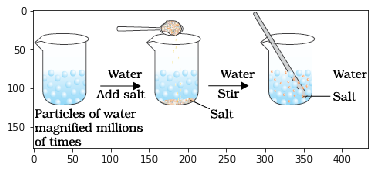

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/764.json
~~~~~~~ Labels  ~~~~~~~~
Water
- Water Add salt Particles of water magnified millions of times
-Water Stir Salt
Salt
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  2   --------
fig
length = 22
Fig. 1.2: Estimating how small are the particles of matter. With every dilution, though the colour becomes light, it is still visible
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/857.png


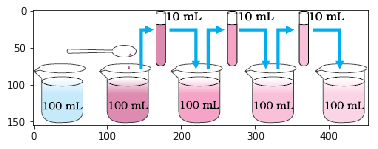

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/857.json
~~~~~~~ Labels  ~~~~~~~~
mL 10
mL 10 ן
mL 10 ך
דורון
| 100 mL
100 mL
100 mL
| 100 ml
| 100 mL
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  3   --------
fig
length = 2
Fig. 1.3
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/bihudance_fmt.jpeg


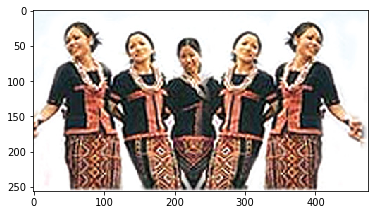

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/bihudance_fmt.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  4   --------
fig + grandparent 
length = 22
Fig. 1.4   What do you observe? In which case was the piston easily pushed in?   What do you infer from your observations?
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/922.png


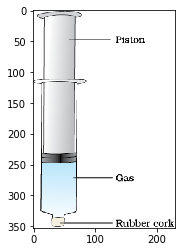

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/922.json
~~~~~~~ Labels  ~~~~~~~~
Piston
Gas
Rubber cork
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  5   --------
fig + grandparent 
length = 14
Fig. 1.10: A model for converting of solid to liquid and liquid to gas.
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/938.png


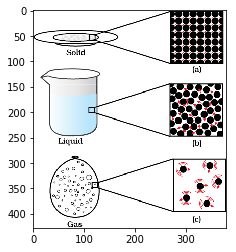

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/938.json
~~~~~~~ Labels  ~~~~~~~~
Solid
( a )
( b )
Liquid
o
( c )
Gas
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  6   --------
 fig + parent
 length = 15
Fig. 1.6: (a) Conversion of ice to water, (b) conversion of water to water vapour
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1002.png


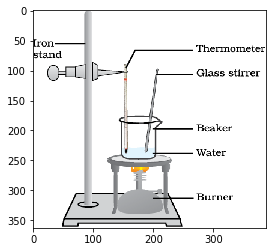

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1002.json
~~~~~~~ Labels  ~~~~~~~~
Iron stand
Thermometer
COF
Glass stirrer
Beaker
Water
1
Burner
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  7   --------
fig
length = 6
Fig. 1.7: Sublimation of ammonium chloride
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1086.png


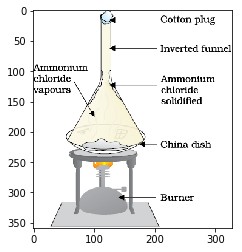

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1086.json
~~~~~~~ Labels  ~~~~~~~~
Cotton plug
Inverted funnel
Ammonium chloride vapours
Ammonium chloride solidified
China dish
Burner
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  8   --------
fig
length = 13
Fig. 1.8: By applying pressure, particles of matter can be brought close together.
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1100.png


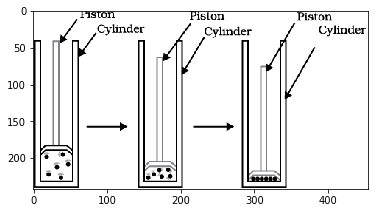

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1100.json
~~~~~~~ Labels  ~~~~~~~~
Piston Cylinder
Piston Cylinder
Piston Cylinder
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  9   --------
fig
length = 9
Fig. 1.9: Interconversion of the three states of matter
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1125.png


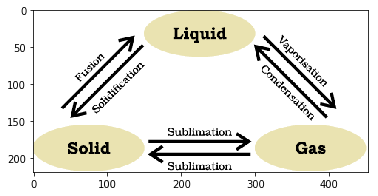

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1125.json
~~~~~~~ Labels  ~~~~~~~~
Liquid
Vaporisation
Condensation
Fusion
Solidification
Sublimation
Solid
Gas
Sublimation
~~~~~~~~~~~~~~~~~~~~~~~~
------- fig  10   --------
fig
length = 14
Fig. 1.10: A model for converting of solid to liquid and liquid to gas.
previous image = ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1242.png


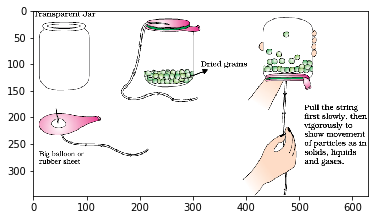

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/1_5239_1/OEBPS/Images/1242.json
~~~~~~~ Labels  ~~~~~~~~
Transparent Jar
Dried grains
Pull the string first slowly , then vigorously to show movement of particles as in solids , liquids and gases .
Big balloon or rubber sheet
~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++   END   +++++++++++++++++++++



In [ ]:
types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

for type_html in types_html_files_list:
    filenames_list = []
    if type_html == "textbooks":
        filenames_list = textbooks_html_files
    if type_html == "papers":
        filenames_list = papers_html_files

    for filename in filenames_list:
        try:
            fp = open(filename, encoding="utf8")
            print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
            print(filename)
        except:
            print("***************  Error while opening file   ***************")
            print(filename)
            print("************************************************************")
        extension = filename.split(".")[-1]
        if extension == "xhtml":
            try:
                print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                soup = BeautifulSoup(fp, 'lxml-xml')
            except Exception as e:
                print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                print(e)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

        elif extension == "html":
            try:
                print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                soup = BeautifulSoup(fp, 'lxml')
            except Exception as e:
                print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                print(e)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

        all_fig = soup.find_all(string=re.compile("^Fig"))
        fig_no = 1
        max_caption_words = 60
        min_caption_words = 3

        for fig in all_fig:
            print("------- fig  "+str(fig_no)+"   --------")

            caption_parent_text = extract_lastfig(fig.parent.parent.get_text())
            caption_grandparent_text = extract_lastfig(fig.parent.parent.parent.get_text())
            fig_text = extract_lastfig(fig)
            fig_caption = ""
            if len(fig_text.split()) >= max_caption_words:
                continue
            elif len(fig_text.split()) >= min_caption_words:
                print(f"fig\nlength = {len(fig.split())}")
                print(fig_text)
                fig_caption = fig_text
            elif len(caption_parent_text.split()) >= max_caption_words:
                print(f"fig\nlength = {len(fig.split())}")
                print(fig_text)
                fig_caption = fig_text
            elif len(caption_grandparent_text.split()) >= max_caption_words:
                print(f" fig + parent\n length = {len(caption_parent_text.split())}")
                print(caption_parent_text)
                fig_caption = caption_parent_text
            else:
                print( f"fig + grandparent \nlength = {len(caption_grandparent_text.split())}")
                print(caption_grandparent_text)
                fig_caption = caption_grandparent_text

            same_el_img = fig.parent.find_all("img")
            prev_img = fig.parent.find_previous("img")


            if same_el_img == []:
                if prev_img == None:
                    print("No image found")
                else:
                    if type_html == "textbooks":
                        image_path = get_image_path(filename,prev_img["src"])
                    if type_html == "papers":
                        image_path = get_image_path_papers(filename,prev_img["src"])
                    # image_path = convert_trans_to_white_bg(image_path)
                    print("previous image = "+ image_path)
            else:
                if type_html == "textbooks":
                    image_path = get_image_path(filename,same_el_img[-1]["src"])
                if type_html == "papers":
                    image_path = get_image_path_papers(filename,same_el_img[-1]["src"])
                # image_path = convert_trans_to_white_bg(image_path)
                print("same tag image = "+ image_path)

            # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
            if type_html == "textbooks":
                ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
            if type_html == "papers":
                ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
            plt.imshow(mpimg.imread(image_path))
            plt.show()
            if os.path.isfile(ocr_json_path):
                print("    Json already exist :  "+ocr_json_path)
                json_file = open(ocr_json_path)
                ocr_dict = json.load(json_file) 
                #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
            else:
                print("  $$$$  Calling google vision API $$$$ ")
                ocr_dict = detect_document(image_path, type_html)
            labels_list = []
            print("~~~~~~~ Labels  ~~~~~~~~")
            if len(ocr_dict["block"]) > 0:
                for i in range(0,len(ocr_dict["block"])):
                    block_dict = ocr_dict["block"][i]
                    print(block_dict["text"])
                    labels_list.append(block_dict["text"])
                    # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])
                    for i in range(0,len(block_dict["paragraph"])):
                        para_dict = block_dict["paragraph"][i]
                        # print("      -",para_dict["text"])
                        # print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
            else:
                print("  NO Labels  ")
            print("~~~~~~~~~~~~~~~~~~~~~~~~")
            fig_no = fig_no + 1
            # print("~~~~~~~~~~~~~~~~~  Labels  ~~~~~~~~~~~~~~~")
            # print(pytesseract.image_to_string(Image.open(image_path)).strip())
            # # detect_text(image_path)
            # print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")



# test: generate example output in html for a model and gaussian smoothing -7

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.png


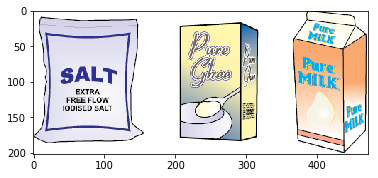

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.json

above header =  Is Matter Around Us Pure?
fig caption =  Fig. 2.1: Some consumable items
below header =  2.1 What is a Mixture?
Fig caption sentence =  figure 2.1: some consumable items. this figure contains pure milk, pure ghee, salt, pure milk, extra free flow iodised salt, pure, milk.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


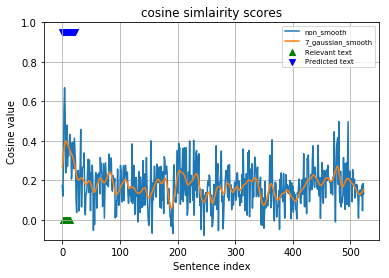

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.png


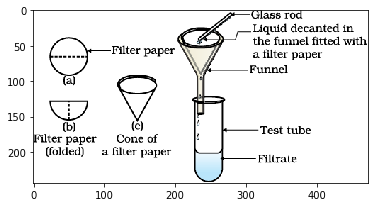

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.json

above header =  2.1.1 Types of mixtures
fig caption =  Fig. 2.2: Filtration
below header =  Questions
Fig caption sentence =  figure 2.2: filtration. this figure contains filter paper, glass rod liquid decanted in the funnel fitted with a filter paper  funnel, test tube, ( b ) ( c ) filter paper cone of ( folded ) a filter paper, 10, filtrate.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


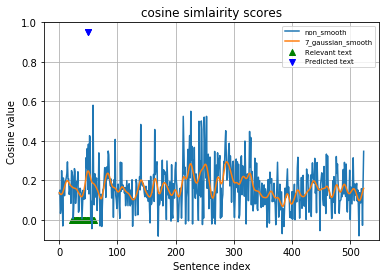

Your max_length is set to 100, but you input_length is only 47. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 100, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.png


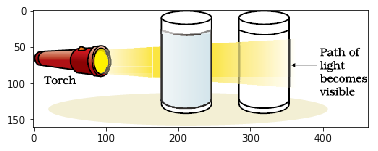

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.json
 

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.3: (a) Solution of copper sulphate does not show
below header =  Properties of a colloid
Fig caption sentence =  figure 2.3: (a) solution of copper sulphate does not show
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


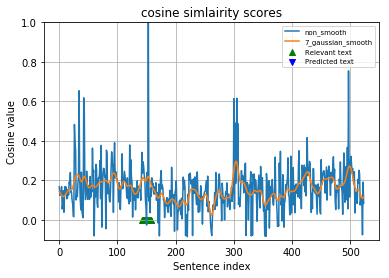

Your max_length is set to 100, but you input_length is only 19. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
Your max_length is set to 100, but you input_length is only 18. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.4_fmt.jpeg


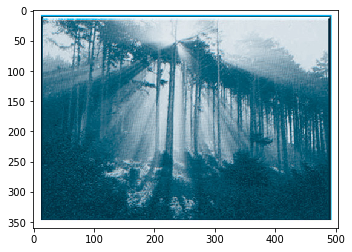

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.json
 

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.4: The Tyndall effect
below header =  Properties of a colloid
Fig caption sentence =  figure 2.4: the tyndall effect
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


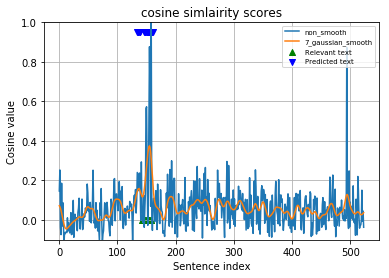

------- fig  5   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.png


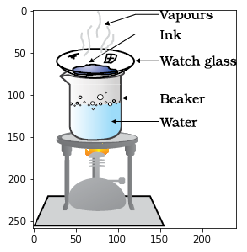

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.json

above header =  2.3.1 How can we obtain coloured component (dye) from blue/black ink?
fig caption =  Fig. 2.5: Evaporation
below header =  Now answer
Fig caption sentence =  figure 2.5: evaporation. this figure contains vapours ink, watch glass, beaker water.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


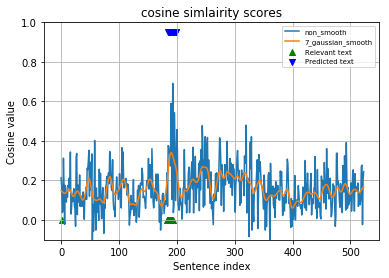

------- fig  6   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.png


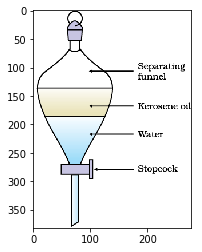

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.json

above header =  2.3.3 How can we separate a mixture of two immiscible liquids?
fig caption =  Fig. 2.6: Separation of immiscible liquids
below header =  Applications
Fig caption sentence =  figure 2.6: separation of immiscible liquids. this figure contains separating funnel, kerosene oil, water, stopcock.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


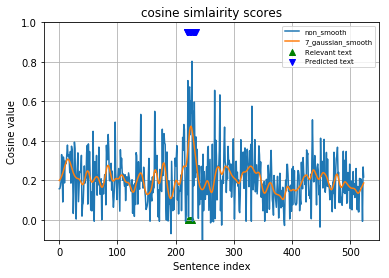

------- fig  7   --------
fig + parent
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.png


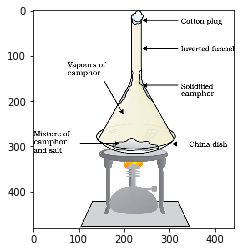

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.json

above header =  2.3.4 How can we separate a mixture of salt and camphor?
fig caption =  Fig. 2.7: Separation of camphor and salt by sublimation
below header =  2.3.5 Is the dye in black ink a single colour?
Fig caption sentence =  figure 2.7: separation of camphor and salt by sublimation. this figure contains cotton plug, inverted funnel, vapours of camphor, solidified camphor, mixture of camphor and salt, china dish.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


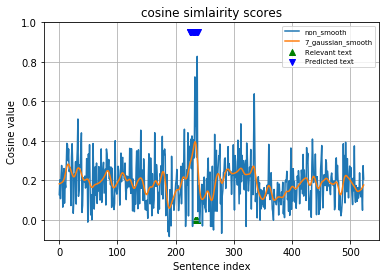

------- fig  8   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.png


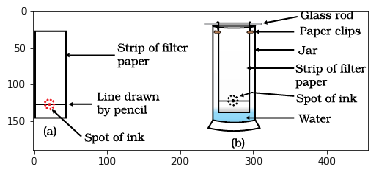

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.json

above header =  2.3.5 Is the dye in black ink a single colour?
fig caption =  Fig. 2.8: Separation of dyes in black ink using
below header =  Now answer
Fig caption sentence =  figure 2.8: separation of dyes in black ink using. this figure contains strip of filter paper, glass rod paper clips jar strip of filter paper spot of ink  water, line drawn by pencil, ( a ), spot of ink, ( b ).
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


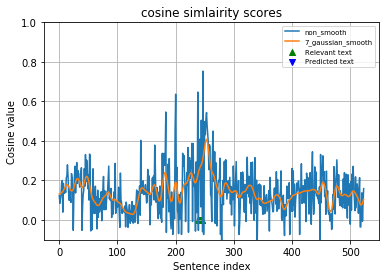

Your max_length is set to 100, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 100, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


------- fig  9   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.png


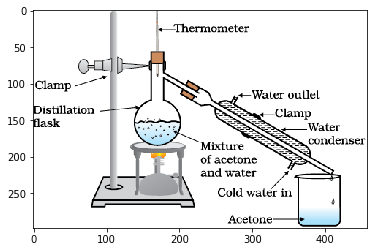

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.json

above header =  2.3.6 How can we separate a mixture of two miscible liquids?
fig caption =  Fig.2.9: Separation of two miscible liquids by distillation
below header =  Now answer
Fig caption sentence =  fig.2.9: separation of two miscible liquids by distillation. this figure contains thermometer, clamp, distillation flask, water outlet clamp water mixture condenser of acetone and water cold water in, acetone.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


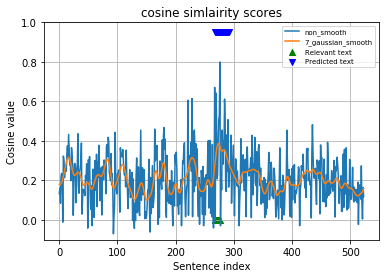

------- fig  10   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.png


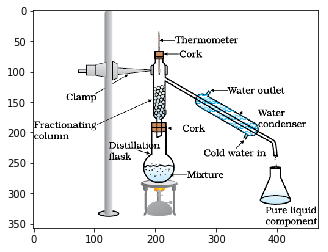

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.json

above header =  Now answer
fig caption =  Fig. 2.10: Fractional distillation
below header =  2.3.7 How can we obtain different gases from air ?
Fig caption sentence =  figure 2.10: fractional distillation. this figure contains  thermometer cork, water outlet, clamp, water condenser, fractionating column, cork, distillation flask, cold water in, mixture, < >, pure liquid component.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


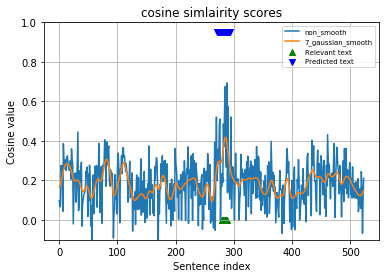

------- fig  11   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.png


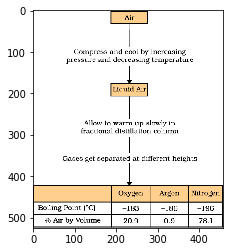

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.json

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.11: Flow diagram shows the process of obtaining gases from air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  figure 2.11: flow diagram shows the process of obtaining gases from air. this figure contains air, compress and cool by increasing pressure and decreasing temperature, liquid air, allow to warm up slowly in fractional distillation column, gases get separated at different heights, oxygen, argon, nitrogen, 183, 186, 196, boiling point (   c ) % air by volume, 20.9, 0.9, 78.1.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


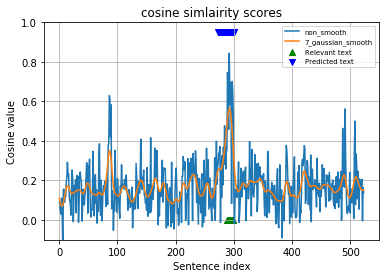

------- fig  12   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.png


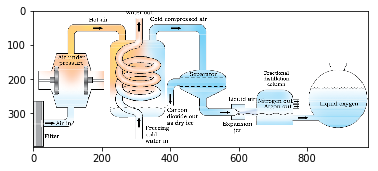

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.json

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.12: Separation of components of air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  figure 2.12: separation of components of air. this figure contains water out cold compressed air, hot air, air under pressure, 000, separator, fractional distillation column, liquid air nitrogen out argon out, liquid oxygen, air in, carbon dioxide out as dry ice freezing cold water in, expansion jet, filter.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


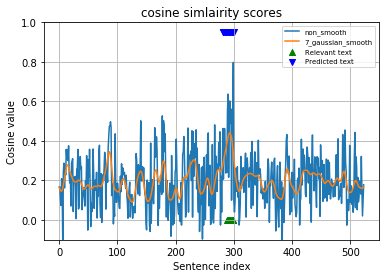

------- fig  13   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.png


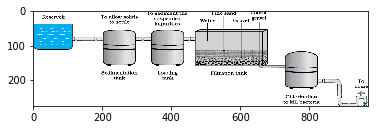

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.json

above header =  Applications
fig caption =  Fig. 2.13: Water purification system in water works
below header =  Questions
Fig caption sentence =  figure 2.13: water purification system in water works. this figure contains coarse, reservoir, to allow solids to settle, to sediment the suspended impurities, fine sand water, gravel gravel, com, sedimentation tank, loading tank, filtration tank, to home, chlorination to kill bacteria.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


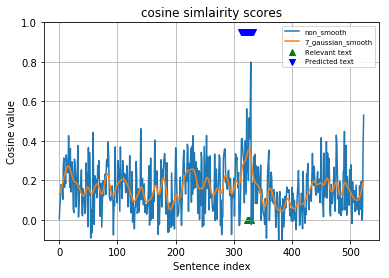

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.png


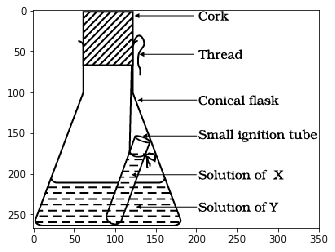

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.json

above header =  3.1.1 Law of conservation of mass
fig caption =  Fig. 3.1: Ignition tube containing solution of X, dipped in a conical flask containing solution of Y.
below header =  3.1.2 Law of constant proportions
Fig caption sentence =  figure 3.1: ignition tube containing solution of x, dipped in a conical flask containing solution of y.. this figure contains cork, thread, conical flask, small ignition tube, solution of x, solution of y.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


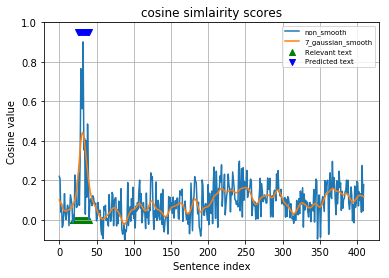

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.2_fmt.jpeg


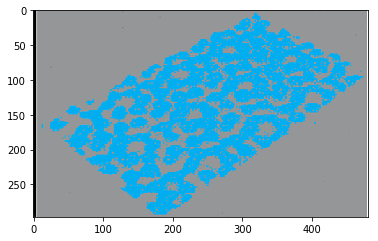

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.json
 

above header =  3.2 What is an Atom?
fig caption =  Fig. 3.2: An image of the surface of silicon
below header =  3.2.1 What are the modern day symbols of atoms of different elements?
Fig caption sentence =  figure 3.2: an image of the surface of silicon
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


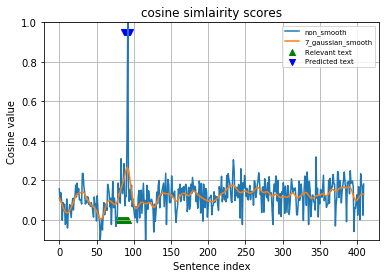

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.png


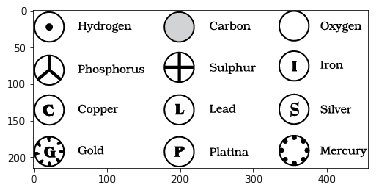

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.json

above header =  3.2.1 What are the modern day symbols of atoms of different elements?
fig caption =  Fig. 3.3: Symbols for some elements as proposed by Dalton
below header =  For example
Fig caption sentence =  figure 3.3: symbols for some elements as proposed by dalton. this figure contains hydrogen, carbon, oxygen, phosphorus, sulphur, i ) iron, c, copper, l, lead, s silver, g, gold, p, platina, mercury.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


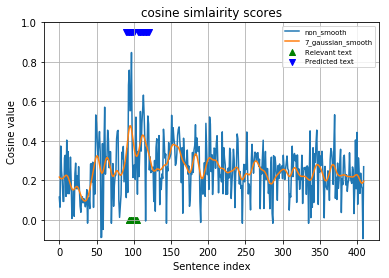

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.png


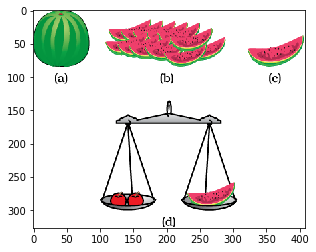

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.json

above header =  3.2.2 Atomic mass
fig caption =  Fig. 3.4 : (a) Watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon
below header =  3.2.3 How do atoms exist?
Fig caption sentence =  figure 3.4 : (a) watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon. this figure contains ( a ), ( b ), ( c ), ( d ).
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


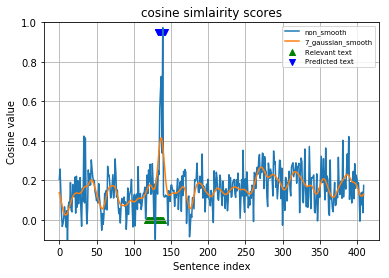

------- fig  5   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.png


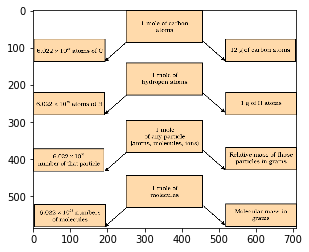

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.json

above header =  3.5.3 Mole concept
fig caption =  Fig. 3.5: Relationship between mole, Avogadro number and mass
below header =  Questions
Fig caption sentence =  figure 3.5: relationship between mole, avogadro number and mass. this figure contains 1 mole of carbon atoms, 6.022 x 10 " atoms of c, 12 g of carbon atoms, 1 mole of hydrogen atoms, 6.022 x 10   atoms of h, 1 g of h atoms, 1 mole of any particle ( atoms , molecules , ions ), 6.022 x 10 number of that particle, relative mass of those particles in grams, 1 mole of molecules, 6.022 x 102 numbers of molecules, molecular mass in grams.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


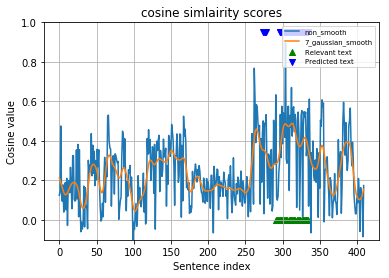

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.png


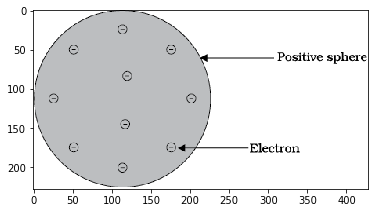

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.json

above header =  4.2.1 Thomson’s model of an atom
fig caption =  Fig.4.1: Thomson s model of an atom
below header =  4.2.2 Rutherford’s model of an atom
Fig caption sentence =  fig.4.1: thomson s model of an atom. this figure contains positive sphere, electron.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


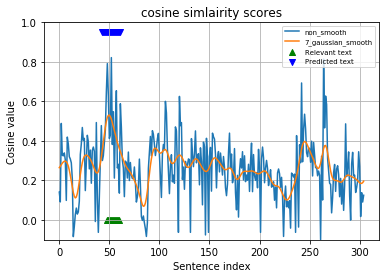

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.png


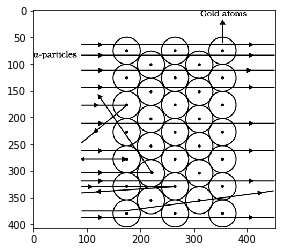

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.json

above header =  4.2.2 Rutherford’s model of an atom
fig caption =  Fig. 4.2: Scattering of  -particles by a gold foil
below header =  Drawbacks of Rutherford’s model of the atom
Fig caption sentence =  figure 4.2: scattering of  -particles by a gold foil. this figure contains gold atoms, a  particles.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


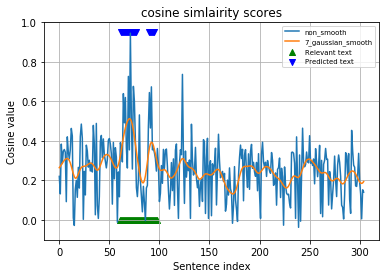

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.png


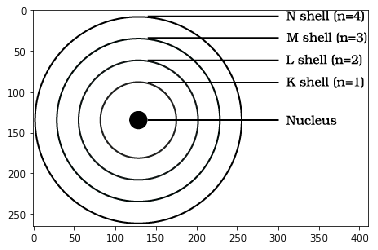

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.json

above header =  4.2.3 Bohr’s model of atom
fig caption =  Fig. 4.3: A few energy levels in an atom
below header =  Questions
Fig caption sentence =  figure 4.3: a few energy levels in an atom. this figure contains n shell ( n = 4 ) m shell ( n = 3 ) l shell ( n = 2 ) k shell ( n = 1 ), nucleus.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


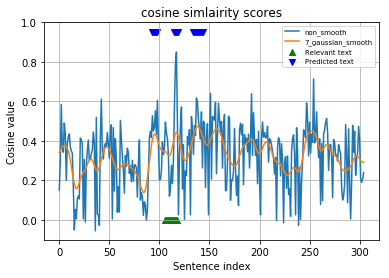

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.png


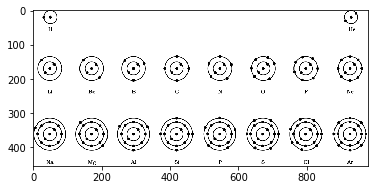

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.json

above header =  4.3 How are Electrons Distributed in Different Orbits (Shells)?
fig caption =  Fig.4.4: Schematic atomic structure of the first eighteen elements
below header =  Questions
Fig caption sentence =  fig.4.4: schematic atomic structure of the first eighteen elements. this figure contains q, h, he, q, o, li, be, b, n, f, ne, na, mg, al, si, p, s, ci, ar.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


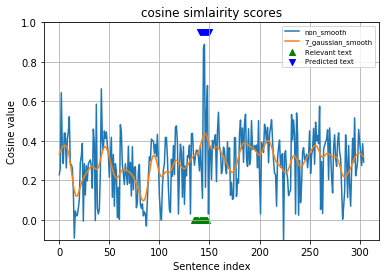

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

***************  Error while opening file   ***************
./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml
************************************************************
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
 ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^
I/O operation on closed file.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png


FileNotFoundError: [Errno 2] No such file or directory: './data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png'

In [ ]:
filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
# papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']
papers_html_files = []
sentence_transformer_model = sentence_transformer_model_nondebug_dict['sentence-transformers/multi-qa-MiniLM-L6-cos-v1']
types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]
smooth_true = 1
no_bounding_sent = 30
h2_optimal_cosine_thershold = 0.08
h6_optimal_cosine_thershold = 0.36


for type_html in types_html_files_list:
    filenames_list = []
    if type_html == "textbooks":
        filenames_list = textbooks_html_files
    if type_html == "papers":
        filenames_list = papers_html_files

    for filename in filenames_list:
        try:
            fp = open(filename, encoding="utf8")
            print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
            print(filename)
        except:
            print("***************  Error while opening file   ***************")
            print(filename)
            print("************************************************************")
        extension = filename.split(".")[-1]
        if extension == "xhtml":
            try:
                print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                soup = BeautifulSoup(fp, 'lxml-xml')
            except Exception as e:
                print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                print(e)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

        elif extension == "html":
            try:
                print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                soup = BeautifulSoup(fp, 'lxml')
            except Exception as e:
                print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                print(e)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        fp.close()
        all_fig = soup.find_all(string=re.compile("^Fig"))
        fig_no = 1
        max_caption_words = 60
        min_caption_words = 3

        full_text = soup.get_text()
        
#         if filename == './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml':
#             output_file = open("output_full_text.txt","w")
#             output_file.write(remove_non_ascii(full_text))
#             output_file.close()

#             output_file = open("output_full_text_str.txt","w")
#             output_file.write(str(full_text.encode('utf8')))
#             output_file.close()

        full_text = remove_multi_newlines(full_text)
        all_sent_list = split_text_to_sent(full_text)
        all_sentence_embeddings = sentence_transformer_model.encode(all_sent_list)

        # for fig in all_fig:
        #     fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
        #     print (fig_caption)
        for fig in all_fig:
            print("------- fig  "+str(fig_no)+"   --------")

            fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
            image_path = extract_imagepath(fig, filename, type_html)

            # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
            if type_html == "textbooks":
                ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
            if type_html == "papers":
                ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
            plt.imshow(mpimg.imread(image_path))
            plt.show()
            if os.path.isfile(ocr_json_path):
                print("    Json already exist :  "+ocr_json_path)
                json_file = open(ocr_json_path)
                ocr_dict = json.load(json_file) 
                #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
            else:
                print("  $$$$  Calling google vision API $$$$ ")
                ocr_dict = detect_document(image_path, type_html)
            labels_list = []
            # print("~~~~~~~ Labels  ~~~~~~~~")
            if len(ocr_dict["block"]) > 0:
                for i in range(0,len(ocr_dict["block"])):
                    block_dict = ocr_dict["block"][i]
                    # print(block_dict["text"]) # uncomment for labels
                    labels_list.append(block_dict["text"].replace("-",""))
                    # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                    # for i in range(0,len(block_dict["paragraph"])):
                    #     para_dict = block_dict["paragraph"][i]
                    #     print("      -",para_dict["text"])
                    #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
            else:
                print(" ")
                # print("  NO Labels  ")
            # print("~~~~~~~~~~~~~~~~~~~~~~~~")

            if type_html == "textbooks":
                above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                if above_header is not None:
                    above_header_text = above_header.get_text()
                else:
                    above_header_text = ""
                while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                    if above_header is not None:
                        above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                        break

                below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                if below_header is not None:
                    below_header_text = below_header.get_text()
                else:
                    below_header_text = ""
                while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                    if below_header is not None:
                        below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                        break

                print("\nabove header = ",above_header_text)
                print("fig caption = ",fig_caption)
                print("below header = ",below_header_text)

                section_text = above_header_text
                if above_header is not None:
                    next_header = above_header.find_next()
                if below_header is not None:
                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"
                else:
                    while next_header is not None:
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                section_text = remove_multi_newlines(section_text)
                sent_list = split_text_to_sent(section_text)
                # print("---------\n",section_text,"\n--------------")
                # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
            if type_html == "papers":
                print("Figure caption = ",fig_caption)
                relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                print(relevant_txt_path + "  read!")
                section_text = relevant_file.read()
                # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                section_text = remove_multi_newlines(section_text)
                sent_list = split_text_to_sent(section_text)
                print ("Length of labels list = ", len(labels_list))
                print ("Length of sent list = ", len(sent_list))
                # for inx in range(0,len(sent_list)):
                #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                relevant_file.close()
            
            fig_caption_sent = ""
            if len(labels_list) > 0:
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")
                fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
            else:
                fig_caption_sent = fig_caption
            
            fig_caption_sent = clean_string(fig_caption_sent).replace("\t", " ").lower()

            print("Fig caption sentence = ",fig_caption_sent)
            print("s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
            # print("t^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            sentence_embeddings = sentence_transformer_model.encode(sent_list)
            # print("u^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
            all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings)[0]
            # print("v^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            no_space_sent_list = []
            for sent in sent_list:
                no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

            no_space_all_sent_list = []
            for sent in all_sent_list:
                no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

            fig_caption_clean = remove_multi_newlines(fig_caption)
            fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
            fig_caption_index = -1
            if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

            sect_index_list = []
            sect_cosine_list = []
            average_cosine_value = np.average(all_cosine_list)
            check_no_space_sent_list = no_space_sent_list.copy()
            for index in range(0,len(all_sent_list)):
                if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                    sect_index_list.append(index)
                    sect_cosine_list.append(all_cosine_list[index])
                    check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
            scatter_x = []
            scatter_y = []
            for sect_index in sect_index_list:
                scatter_x.append(sect_index)
                scatter_y.append(0)
            plt.scatter(scatter_x, scatter_y, label = "Relevant text", marker = '^', c = "green")

            if smooth_true == 1:
                smooth_no = -7 # gaussian smooth with window size 7
                all_cosine_list = moving_average(np.array(all_cosine_list), smooth_no).tolist()
                plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                example_folder = "h2_smooth_examples/"
            else:
                example_folder = "h2_nosmooth_examples/"
            prediction_index_list = []
            for index in range(0,len(all_sent_list)):
                if abs(index - fig_caption_index) <= no_bounding_sent and all_cosine_list[index] - average_cosine_value >= h2_optimal_cosine_thershold:
                    prediction_index_list.append(index)
            scatter_x = []
            scatter_y = []
            for pred_index in prediction_index_list:
                scatter_x.append(pred_index)
                scatter_y.append(0.95)
            plt.scatter(scatter_x, scatter_y, label = "Predicted text", marker = 'v', c = "blue")

            plt.xlabel('Sentence index')
            plt.ylabel('Cosine value')
            plt.title("cosine simlairity scores")
            plt.legend()
            plt.grid(True)
            plt.ylim(-0.1, 1)
            plt.legend(loc="upper right",fontsize="x-small")
            scatter_plot_path = example_folder+"scatter_plots/"+str(fig_no)+'_'+type_html+'_'+filename.replace("/","_")+'.png'
            example_html_path = example_folder+str(fig_no)+'_'+type_html+'_'+filename.replace("/","_")+'.html'
            plt.savefig(scatter_plot_path,dpi=500)
            plt.show()

            # check_no_space_sent_list = no_space_sent_list.copy()
            prediction_text = fig_caption
            prediction_text_labels = fig_caption_sent
            for pred_index in prediction_index_list:
                prediction_text = prediction_text +". "+all_sent_list[pred_index]
                prediction_text_labels = prediction_text_labels +". "+ all_sent_list[pred_index]
            if len(prediction_text) > 1020:
                prediction_text = prediction_text[:1020]
            if len(prediction_text_labels) > 1020:
                prediction_text_labels = prediction_text_labels[:1020]
            summary_text = pipeline_summarizer(prediction_text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']         
            summary_text_labels = pipeline_summarizer(prediction_text_labels, max_length=100, min_length=30, do_sample=False)[0]['summary_text']       
            original_stdout = sys.stdout
            out_file = open(example_html_path, 'w')
            sys.stdout = out_file
            print(""" <!DOCTYPE html>
                    <html>
                    <body style="background-color:black;">""")
            print('<img src=".'+image_path+'" style="background-color:white;">')
            print('<h2 style="color:white;">Fig caption sentence = ',fig_caption_sent,'</h2>')
            print('<img src="scatter_plots/'+scatter_plot_path.split("/")[-1]+'" style="background-color:white;" width="auto" height="400">')
            print('<p style="color:silver;"><b>Summary without labels:</b>'+summary_text+'</p><br>')
            print('<p style="color:silver;"><b>Summary with labels:</b>'+summary_text_labels+'</p><br>')
            print("<p>----------------- START ---------------------------</p>")
            print('<ul><li><h3 style="color:limegreen;">True positive</h3></li>')
            print('<li><h3 style="color:darkgreen;">False negative</h3></li>')
            print('<li><h3 style="color:brown;">False positive</h3></li>')
            print('<li><h3 style="color:grey;">True negative</h3></li></ul>')
            for index in range(0,len(all_sent_list)):
                if index in prediction_index_list:
                    # cosine_value = all_cosine_list[index]
                    if index in sect_index_list:
                        print( '<p style="color:limegreen;">'+str(index)+": ", all_sent_list[index], "</p>")
                    else:
                        print( '<p style="color:brown;">'+str(index)+": ", all_sent_list[index], "</p>")
                else:
                    if index in sect_index_list:
                        print( '<p style="color:darkgreen;">'+str(index)+": ", all_sent_list[index], "</p>")
                    else:
                        print( '<p style="color:grey;">'+str(index)+": ", all_sent_list[index], "</p>")
                        
                # if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                #     cosine_value = all_cosine_list[index]
                #     if cosine_value > 0.35:
                #         print( '<p style="color:limegreen;">## '+str(index)+": ", all_sent_list[index], "</p>")
                #     elif cosine_value > 0.2:
                #         print( '<p style="color:darkturquoise;">## '+str(index)+": ", all_sent_list[index], "</p>")
                #     else:
                #         print( '<p style="color:grey;">## '+str(index)+": ", all_sent_list[index], "</p>")
                # else:
                #     cosine_value = all_cosine_list[index]
                #     if cosine_value > 0.35:
                #         print( '<p style="color:limegreen;">', all_sent_list[index], "</p>")
                #     elif cosine_value > 0.2:
                #         print( '<p style="color:darkturquoise;">', all_sent_list[index], "</p>")
                #     else:
                #         print( '<p style="color:grey;">', all_sent_list[index], "</p>")
            print("<p>----------------- END ---------------------------</p>")
            print("""</body>
                    </html>""")

            # for index in range(0,len(all_sent_list)):
            #     if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
            #         cosine_value = all_cosine_list[index]
            #         if cosine_value > 0.35:
            #             print( "## "+str(index)+": ", f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.2:
            #             print( "## "+str(index)+": ", f"{bcolors.OKCYAN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.15:
            #             print( "## "+str(index)+": ", f"{bcolors.WARNING}{all_sent_list[index]}{bcolors.ENDC}")
            #         else:
            #             print( "## "+str(index)+": ", all_sent_list[index])
            #     else:
            #         cosine_value = all_cosine_list[index]
            #         if cosine_value > 0.35:
            #             print( f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.2:
            #             print( f"{bcolors.OKCYAN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.15:
            #             print( f"{bcolors.WARNING}{all_sent_list[index]}{bcolors.ENDC}")
            #         else:
            #             print( all_sent_list[index])

            sys.stdout = original_stdout
            out_file.close()
            fig_no = fig_no + 1

        print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")


In [ ]:
# !pip install  sentence-transformers

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.png


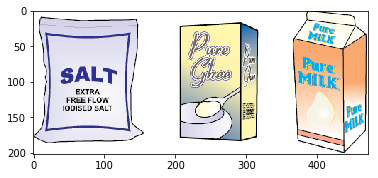

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.json

above header =  Is Matter Around Us Pure?
fig caption =  Fig. 2.1: Some consumable items
below header =  2.1 What is a Mixture?
Fig caption sentence =  figure 2.1: some consumable items. this figure contains pure milk, pure ghee, salt, pure milk, extra free flow iodised salt, pure, milk.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


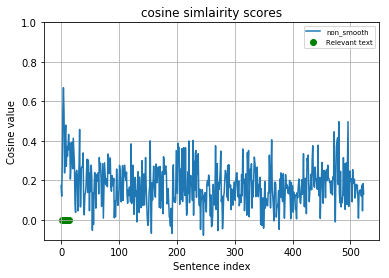

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.png


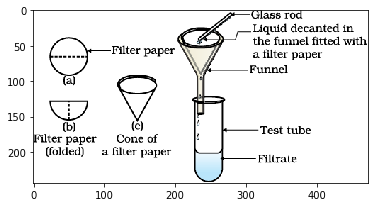

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.json

above header =  2.1.1 Types of mixtures
fig caption =  Fig. 2.2: Filtration
below header =  Questions
Fig caption sentence =  figure 2.2: filtration. this figure contains filter paper, glass rod liquid decanted in the funnel fitted with a filter paper  funnel, test tube, ( b ) ( c ) filter paper cone of ( folded ) a filter paper, 10, filtrate.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


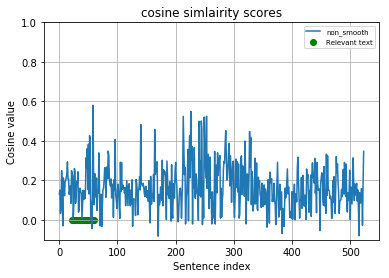

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.png


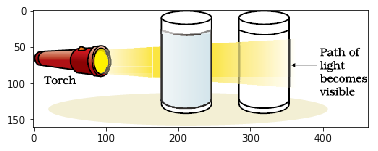

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.json
 

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.3: (a) Solution of copper sulphate does not show
below header =  Properties of a colloid
Fig caption sentence =  figure 2.3: (a) solution of copper sulphate does not show
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


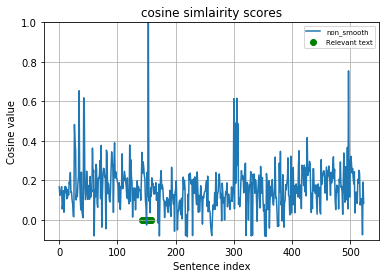

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.4_fmt.jpeg


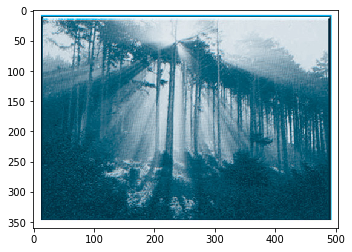

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.json
 

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.4: The Tyndall effect
below header =  Properties of a colloid
Fig caption sentence =  figure 2.4: the tyndall effect
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


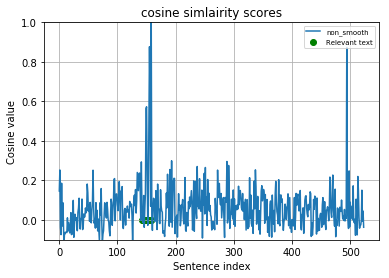

------- fig  5   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.png


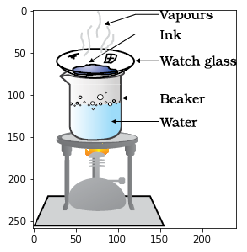

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.json

above header =  2.3.1 How can we obtain coloured component (dye) from blue/black ink?
fig caption =  Fig. 2.5: Evaporation
below header =  Now answer
Fig caption sentence =  figure 2.5: evaporation. this figure contains vapours ink, watch glass, beaker water.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


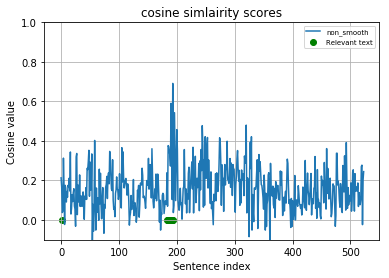

------- fig  6   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.png


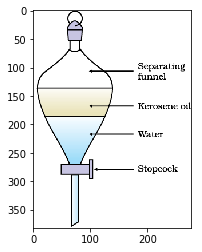

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.json

above header =  2.3.3 How can we separate a mixture of two immiscible liquids?
fig caption =  Fig. 2.6: Separation of immiscible liquids
below header =  Applications
Fig caption sentence =  figure 2.6: separation of immiscible liquids. this figure contains separating funnel, kerosene oil, water, stopcock.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


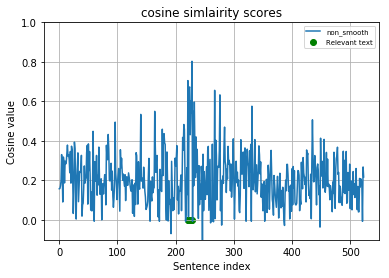

------- fig  7   --------
fig + parent
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.png


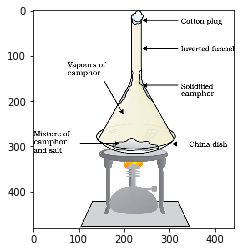

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.json

above header =  2.3.4 How can we separate a mixture of salt and camphor?
fig caption =  Fig. 2.7: Separation of camphor and salt by sublimation
below header =  2.3.5 Is the dye in black ink a single colour?
Fig caption sentence =  figure 2.7: separation of camphor and salt by sublimation. this figure contains cotton plug, inverted funnel, vapours of camphor, solidified camphor, mixture of camphor and salt, china dish.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


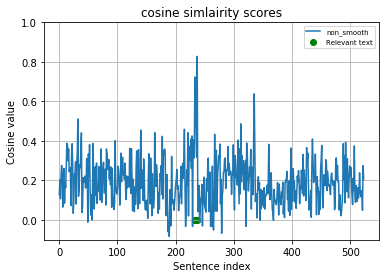

------- fig  8   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.png


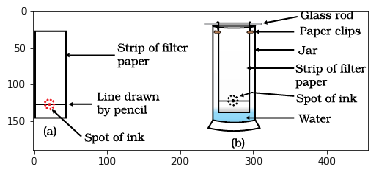

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.json

above header =  2.3.5 Is the dye in black ink a single colour?
fig caption =  Fig. 2.8: Separation of dyes in black ink using
below header =  Now answer
Fig caption sentence =  figure 2.8: separation of dyes in black ink using. this figure contains strip of filter paper, glass rod paper clips jar strip of filter paper spot of ink  water, line drawn by pencil, ( a ), spot of ink, ( b ).
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


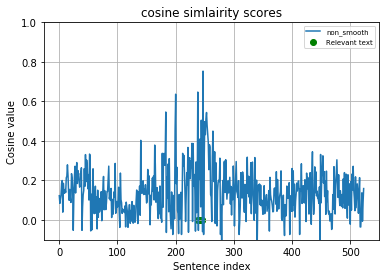

------- fig  9   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.png


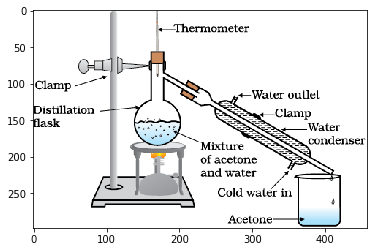

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.json

above header =  2.3.6 How can we separate a mixture of two miscible liquids?
fig caption =  Fig.2.9: Separation of two miscible liquids by distillation
below header =  Now answer
Fig caption sentence =  fig.2.9: separation of two miscible liquids by distillation. this figure contains thermometer, clamp, distillation flask, water outlet clamp water mixture condenser of acetone and water cold water in, acetone.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


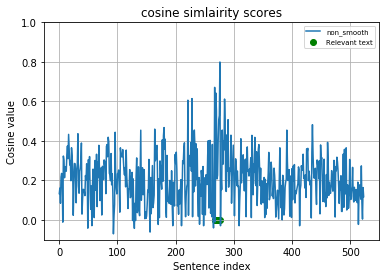

------- fig  10   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.png


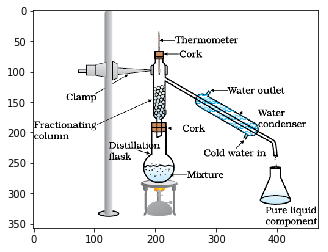

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.json

above header =  Now answer
fig caption =  Fig. 2.10: Fractional distillation
below header =  2.3.7 How can we obtain different gases from air ?
Fig caption sentence =  figure 2.10: fractional distillation. this figure contains  thermometer cork, water outlet, clamp, water condenser, fractionating column, cork, distillation flask, cold water in, mixture, < >, pure liquid component.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


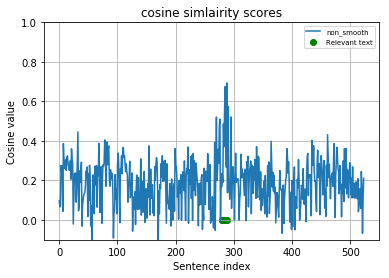

------- fig  11   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.png


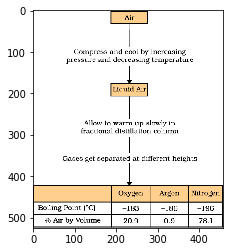

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.json

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.11: Flow diagram shows the process of obtaining gases from air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  figure 2.11: flow diagram shows the process of obtaining gases from air. this figure contains air, compress and cool by increasing pressure and decreasing temperature, liquid air, allow to warm up slowly in fractional distillation column, gases get separated at different heights, oxygen, argon, nitrogen, 183, 186, 196, boiling point (   c ) % air by volume, 20.9, 0.9, 78.1.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


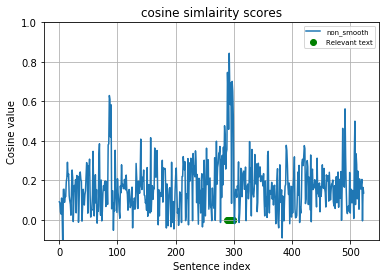

------- fig  12   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.png


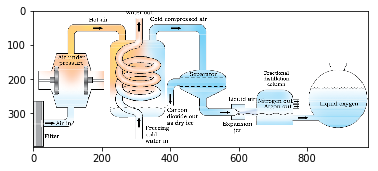

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.json

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.12: Separation of components of air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  figure 2.12: separation of components of air. this figure contains water out cold compressed air, hot air, air under pressure, 000, separator, fractional distillation column, liquid air nitrogen out argon out, liquid oxygen, air in, carbon dioxide out as dry ice freezing cold water in, expansion jet, filter.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


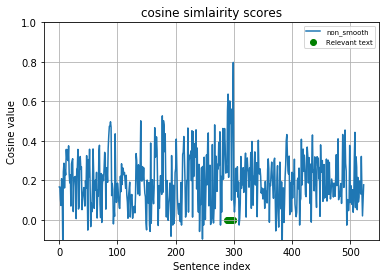

------- fig  13   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.png


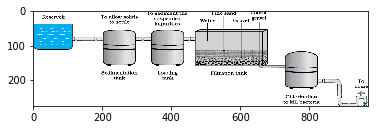

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.json

above header =  Applications
fig caption =  Fig. 2.13: Water purification system in water works
below header =  Questions
Fig caption sentence =  figure 2.13: water purification system in water works. this figure contains coarse, reservoir, to allow solids to settle, to sediment the suspended impurities, fine sand water, gravel gravel, com, sedimentation tank, loading tank, filtration tank, to home, chlorination to kill bacteria.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


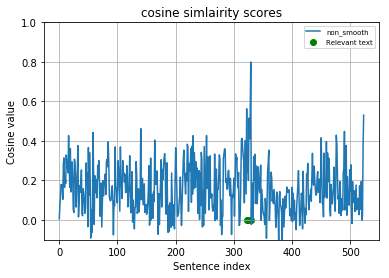

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.png


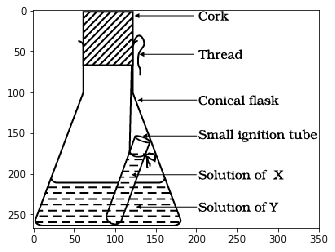

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.json

above header =  3.1.1 Law of conservation of mass
fig caption =  Fig. 3.1: Ignition tube containing solution of X, dipped in a conical flask containing solution of Y.
below header =  3.1.2 Law of constant proportions
Fig caption sentence =  figure 3.1: ignition tube containing solution of x, dipped in a conical flask containing solution of y.. this figure contains cork, thread, conical flask, small ignition tube, solution of x, solution of y.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


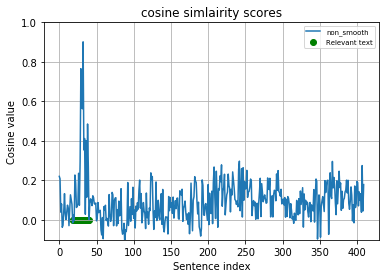

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.2_fmt.jpeg


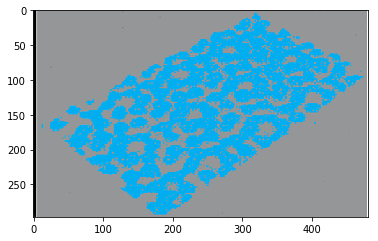

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.json
 

above header =  3.2 What is an Atom?
fig caption =  Fig. 3.2: An image of the surface of silicon
below header =  3.2.1 What are the modern day symbols of atoms of different elements?
Fig caption sentence =  figure 3.2: an image of the surface of silicon
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


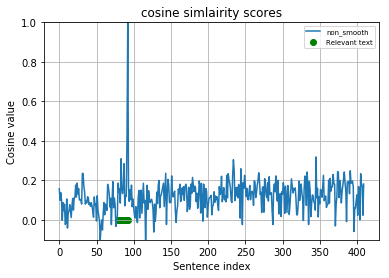

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.png


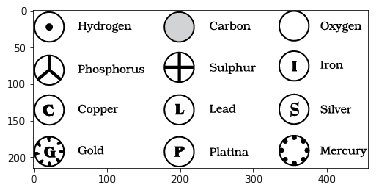

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.json

above header =  3.2.1 What are the modern day symbols of atoms of different elements?
fig caption =  Fig. 3.3: Symbols for some elements as proposed by Dalton
below header =  For example
Fig caption sentence =  figure 3.3: symbols for some elements as proposed by dalton. this figure contains hydrogen, carbon, oxygen, phosphorus, sulphur, i ) iron, c, copper, l, lead, s silver, g, gold, p, platina, mercury.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


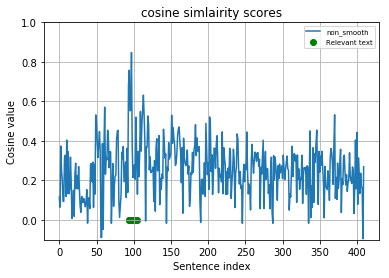

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.png


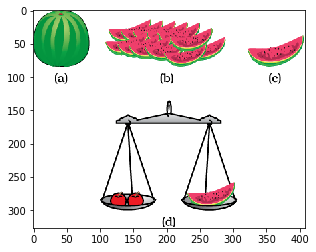

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.json

above header =  3.2.2 Atomic mass
fig caption =  Fig. 3.4 : (a) Watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon
below header =  3.2.3 How do atoms exist?
Fig caption sentence =  figure 3.4 : (a) watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon. this figure contains ( a ), ( b ), ( c ), ( d ).
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


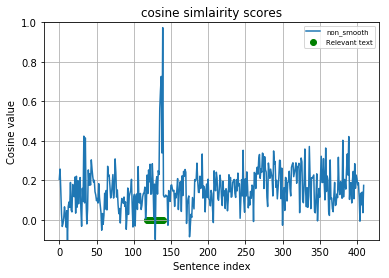

------- fig  5   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.png


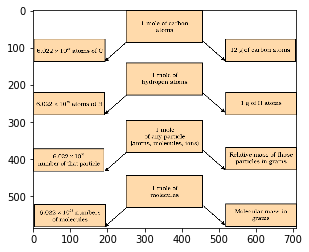

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.json

above header =  3.5.3 Mole concept
fig caption =  Fig. 3.5: Relationship between mole, Avogadro number and mass
below header =  Questions
Fig caption sentence =  figure 3.5: relationship between mole, avogadro number and mass. this figure contains 1 mole of carbon atoms, 6.022 x 10 " atoms of c, 12 g of carbon atoms, 1 mole of hydrogen atoms, 6.022 x 10   atoms of h, 1 g of h atoms, 1 mole of any particle ( atoms , molecules , ions ), 6.022 x 10 number of that particle, relative mass of those particles in grams, 1 mole of molecules, 6.022 x 102 numbers of molecules, molecular mass in grams.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


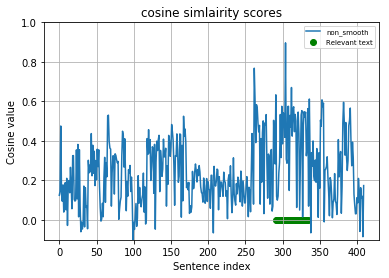

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.png


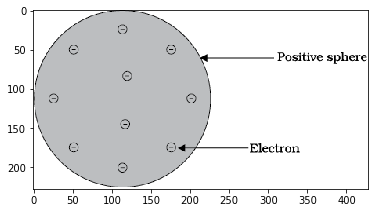

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.json

above header =  4.2.1 Thomson’s model of an atom
fig caption =  Fig.4.1: Thomson s model of an atom
below header =  4.2.2 Rutherford’s model of an atom
Fig caption sentence =  fig.4.1: thomson s model of an atom. this figure contains positive sphere, electron.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


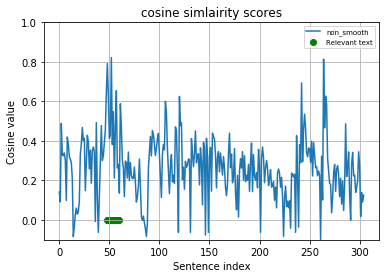

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.png


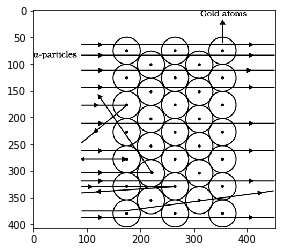

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.json

above header =  4.2.2 Rutherford’s model of an atom
fig caption =  Fig. 4.2: Scattering of  -particles by a gold foil
below header =  Drawbacks of Rutherford’s model of the atom
Fig caption sentence =  figure 4.2: scattering of  -particles by a gold foil. this figure contains gold atoms, a  particles.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


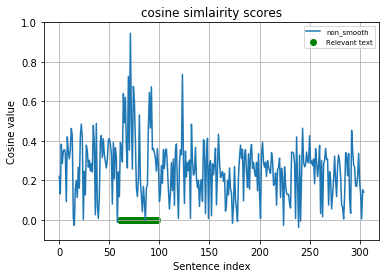

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.png


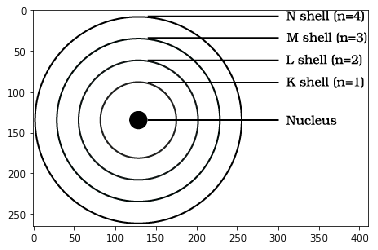

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.json

above header =  4.2.3 Bohr’s model of atom
fig caption =  Fig. 4.3: A few energy levels in an atom
below header =  Questions
Fig caption sentence =  figure 4.3: a few energy levels in an atom. this figure contains n shell ( n = 4 ) m shell ( n = 3 ) l shell ( n = 2 ) k shell ( n = 1 ), nucleus.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


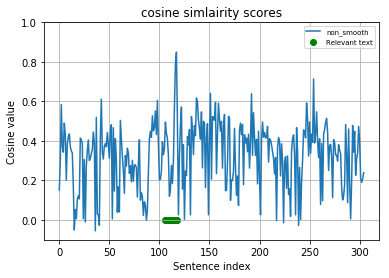

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.png


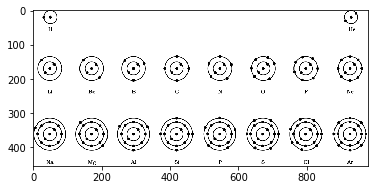

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.json

above header =  4.3 How are Electrons Distributed in Different Orbits (Shells)?
fig caption =  Fig.4.4: Schematic atomic structure of the first eighteen elements
below header =  Questions
Fig caption sentence =  fig.4.4: schematic atomic structure of the first eighteen elements. this figure contains q, h, he, q, o, li, be, b, n, f, ne, na, mg, al, si, p, s, ci, ar.
s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


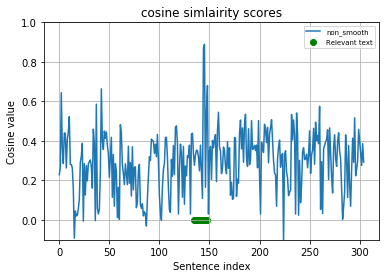

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

***************  Error while opening file   ***************
./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml
************************************************************
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
 ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^
I/O operation on closed file.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png


FileNotFoundError: [Errno 2] No such file or directory: './data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png'

In [ ]:

filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
# papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']
papers_html_files = []
sentence_transformer_model = sentence_transformer_model_nondebug_dict['sentence-transformers/multi-qa-MiniLM-L6-cos-v1']
types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]
smooth_true = 0

for type_html in types_html_files_list:
    filenames_list = []
    if type_html == "textbooks":
        filenames_list = textbooks_html_files
    if type_html == "papers":
        filenames_list = papers_html_files

    for filename in filenames_list:
        try:
            fp = open(filename, encoding="utf8")
            print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
            print(filename)
        except:
            print("***************  Error while opening file   ***************")
            print(filename)
            print("************************************************************")
        extension = filename.split(".")[-1]
        if extension == "xhtml":
            try:
                print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                soup = BeautifulSoup(fp, 'lxml-xml')
            except Exception as e:
                print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                print(e)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

        elif extension == "html":
            try:
                print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                soup = BeautifulSoup(fp, 'lxml')
            except Exception as e:
                print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                print(e)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        fp.close()
        all_fig = soup.find_all(string=re.compile("^Fig"))
        fig_no = 1
        max_caption_words = 60
        min_caption_words = 3

        full_text = soup.get_text()
        
#         if filename == './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml':
#             output_file = open("output_full_text.txt","w")
#             output_file.write(remove_non_ascii(full_text))
#             output_file.close()

#             output_file = open("output_full_text_str.txt","w")
#             output_file.write(str(full_text.encode('utf8')))
#             output_file.close()

        full_text = remove_multi_newlines(full_text)
        all_sent_list = split_text_to_sent(full_text)
        all_sentence_embeddings = sentence_transformer_model.encode(all_sent_list)

        # for fig in all_fig:
        #     fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
        #     print (fig_caption)
        for fig in all_fig:
            print("------- fig  "+str(fig_no)+"   --------")

            fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
            image_path = extract_imagepath(fig, filename, type_html)

            # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
            if type_html == "textbooks":
                ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
            if type_html == "papers":
                ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
            plt.imshow(mpimg.imread(image_path))
            plt.show()
            if os.path.isfile(ocr_json_path):
                print("    Json already exist :  "+ocr_json_path)
                json_file = open(ocr_json_path)
                ocr_dict = json.load(json_file) 
                #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
            else:
                print("  $$$$  Calling google vision API $$$$ ")
                ocr_dict = detect_document(image_path, type_html)
            labels_list = []
            # print("~~~~~~~ Labels  ~~~~~~~~")
            if len(ocr_dict["block"]) > 0:
                for i in range(0,len(ocr_dict["block"])):
                    block_dict = ocr_dict["block"][i]
                    # print(block_dict["text"]) # uncomment for labels
                    labels_list.append(block_dict["text"].replace("-",""))
                    # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                    # for i in range(0,len(block_dict["paragraph"])):
                    #     para_dict = block_dict["paragraph"][i]
                    #     print("      -",para_dict["text"])
                    #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
            else:
                print(" ")
                # print("  NO Labels  ")
            # print("~~~~~~~~~~~~~~~~~~~~~~~~")

            if type_html == "textbooks":
                above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                if above_header is not None:
                    above_header_text = above_header.get_text()
                else:
                    above_header_text = ""
                while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                    if above_header is not None:
                        above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                        break

                below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                if below_header is not None:
                    below_header_text = below_header.get_text()
                else:
                    below_header_text = ""
                while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                    if below_header is not None:
                        below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                        break

                print("\nabove header = ",above_header_text)
                print("fig caption = ",fig_caption)
                print("below header = ",below_header_text)

                section_text = above_header_text
                if above_header is not None:
                    next_header = above_header.find_next()
                if below_header is not None:
                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"
                else:
                    while next_header is not None:
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                section_text = remove_multi_newlines(section_text)
                sent_list = split_text_to_sent(section_text)
                # print("---------\n",section_text,"\n--------------")
                # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
            if type_html == "papers":
                print("Figure caption = ",fig_caption)
                relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                print(relevant_txt_path + "  read!")
                section_text = relevant_file.read()
                # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                section_text = remove_multi_newlines(section_text)
                sent_list = split_text_to_sent(section_text)
                print ("Length of labels list = ", len(labels_list))
                print ("Length of sent list = ", len(sent_list))
                # for inx in range(0,len(sent_list)):
                #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                relevant_file.close()
            
            fig_caption_sent = ""
            if len(labels_list) > 0:
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")
                fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
            else:
                fig_caption_sent = fig_caption
            
            fig_caption_sent = clean_string(fig_caption_sent).replace("\t", " ").lower()

            print("Fig caption sentence = ",fig_caption_sent)
            print("s^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
            # print("t^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            sentence_embeddings = sentence_transformer_model.encode(sent_list)
            # print("u^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
            all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings)[0]
            # print("v^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            no_space_sent_list = []
            for sent in sent_list:
                no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

            sect_index_list = []
            sect_cosine_list = []
            check_no_space_sent_list = no_space_sent_list.copy()
            for index in range(0,len(all_sent_list)):
                if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                    sect_index_list.append(index)
                    sect_cosine_list.append(all_cosine_list[index])
                    check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
            scatter_x = []
            scatter_y = []
            for sect_index in sect_index_list:
                scatter_x.append(sect_index)
                scatter_y.append(0)
            plt.scatter(scatter_x, scatter_y, label = "Relevant text", marker = 'o', c = "green")
            if smooth_true == 1:
                smooth_no = -7 # gaussian smooth with window size 7
                all_cosine_list = moving_average(np.array(all_cosine_list), smooth_no).tolist()
                plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                example_folder = "smooth_examples/"
            else:
                example_folder = "nosmooth_examples/"
            plt.xlabel('Sentence index')
            plt.ylabel('Cosine value')
            plt.title("cosine simlairity scores")
            plt.legend()
            plt.grid(True)
            plt.ylim(-0.1, 1)
            plt.legend(loc="upper right",fontsize="x-small")
            scatter_plot_path = example_folder+"scatter_plots/"+str(fig_no)+'_'+type_html+'_'+filename.replace("/","_")+'.png'
            example_html_path = example_folder+str(fig_no)+'_'+type_html+'_'+filename.replace("/","_")+'.html'
            plt.savefig(scatter_plot_path,dpi=500)
            plt.show()

            check_no_space_sent_list = no_space_sent_list.copy()
            original_stdout = sys.stdout
            out_file = open(example_html_path, 'w')
            sys.stdout = out_file
            print(""" <!DOCTYPE html>
                    <html>
                    <body style="background-color:black;">""")
            print('<img src=".'+image_path+'" style="background-color:white;">')
            print('<h2 style="color:white;">Fig caption sentence = ',fig_caption_sent,'</h2>')
            print('<img src="scatter_plots/'+scatter_plot_path.split("/")[-1]+'" style="background-color:white;" width="auto" height="400">')
            print("<p>----------------- START ---------------------------</p>")
            for index in range(0,len(all_sent_list)):
                if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                    cosine_value = all_cosine_list[index]
                    if cosine_value > 0.35:
                        print( '<p style="color:limegreen;">## '+str(index)+": ", all_sent_list[index], "</p>")
                    elif cosine_value > 0.2:
                        print( '<p style="color:darkturquoise;">## '+str(index)+": ", all_sent_list[index], "</p>")
                    else:
                        print( '<p style="color:grey;">## '+str(index)+": ", all_sent_list[index], "</p>")
                else:
                    cosine_value = all_cosine_list[index]
                    if cosine_value > 0.35:
                        print( '<p style="color:limegreen;">', all_sent_list[index], "</p>")
                    elif cosine_value > 0.2:
                        print( '<p style="color:darkturquoise;">', all_sent_list[index], "</p>")
                    else:
                        print( '<p style="color:grey;">', all_sent_list[index], "</p>")
            print("<p>----------------- END ---------------------------</p>")
            print("""</body>
                    </html>""")

            # for index in range(0,len(all_sent_list)):
            #     if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
            #         cosine_value = all_cosine_list[index]
            #         if cosine_value > 0.35:
            #             print( "## "+str(index)+": ", f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.2:
            #             print( "## "+str(index)+": ", f"{bcolors.OKCYAN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.15:
            #             print( "## "+str(index)+": ", f"{bcolors.WARNING}{all_sent_list[index]}{bcolors.ENDC}")
            #         else:
            #             print( "## "+str(index)+": ", all_sent_list[index])
            #     else:
            #         cosine_value = all_cosine_list[index]
            #         if cosine_value > 0.35:
            #             print( f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.2:
            #             print( f"{bcolors.OKCYAN}{all_sent_list[index]}{bcolors.ENDC}")
            #         elif cosine_value > 0.15:
            #             print( f"{bcolors.WARNING}{all_sent_list[index]}{bcolors.ENDC}")
            #         else:
            #             print( all_sent_list[index])

            sys.stdout = original_stdout
            out_file.close()
            # for index in range(0,len(sent_list)):
            #     cosine_value = smooth_cosine_list[index]
            #     if cosine_value > 0.35:
            #         print( str(index)+": ", f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
            #     elif cosine_value > 0.2:
            #         print( str(index)+": ", f"{bcolors.OKCYAN}{sent_list[index]}{bcolors.ENDC}")
            #     elif cosine_value > 0.15:
            #         print( str(index)+": ", f"{bcolors.WARNING}{sent_list[index]}{bcolors.ENDC}")
            #     else:
            #         print( str(index)+": ", sent_list[index])
            # print("e^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fig_no = fig_no + 1

        print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")


# test: text-text similarity all models accuracy test


++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.png


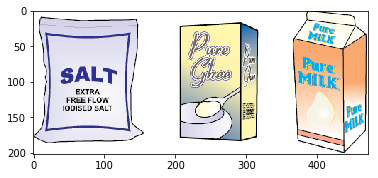

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.json
~~~~~~~ Labels  ~~~~~~~~
Pure MILK
Pure Ghee
SALT
Pure MILK
EXTRA FREE FLOW IODISED SALT
Pure
MILK
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  Is Matter Around Us Pure?
fig caption =  Fig. 2.1: Some consumable items
below header =  2.1 What is a Mixture?
Fig caption sentence =  Figure 2.1: Some consumable items. This figure contains Pure MILK, Pure Ghee, SALT, Pure MILK, EXTRA FREE FLOW IODISED SALT, Pure, MILK.


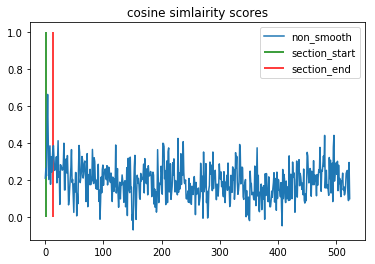

------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.png


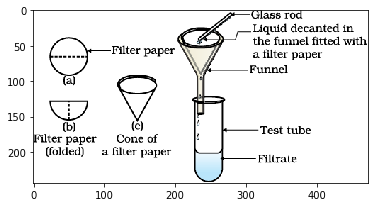

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.json
~~~~~~~ Labels  ~~~~~~~~
-Filter paper
-Glass rod Liquid decanted in the funnel fitted with a filter paper - Funnel
-Test tube
( b ) ( c ) Filter paper Cone of ( folded ) a filter paper
10
-Filtrate
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.1.1 Types of mixtures
fig caption =  Fig. 2.2: Filtration
below header =  Questions
Fig caption sentence =  Figure 2.2: Filtration. This figure contains Filter paper, Glass rod Liquid decanted in the funnel fitted with a filter paper  Funnel, Test tube, ( b ) ( c ) Filter paper Cone of ( folded ) a filter paper, 10, Filtrate.


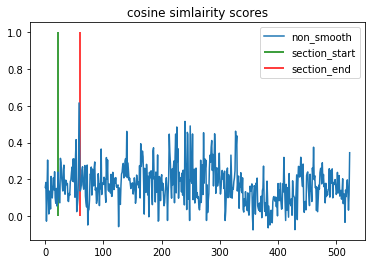

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.png


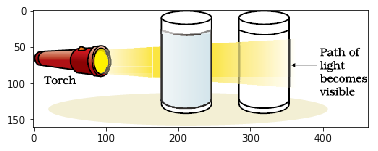

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.3: (a) Solution of copper sulphate does not show
below header =  Properties of a colloid
Fig caption sentence =  Figure 2.3: (a) Solution of copper sulphate does not show


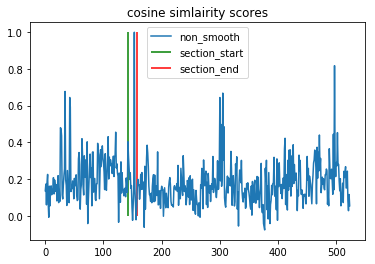

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.4_fmt.jpeg


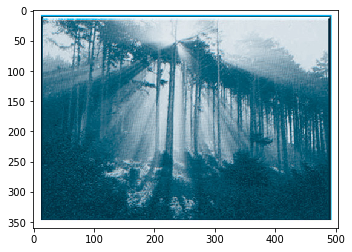

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.4: The Tyndall effect
below header =  Properties of a colloid
Fig caption sentence =  Figure 2.4: The Tyndall effect


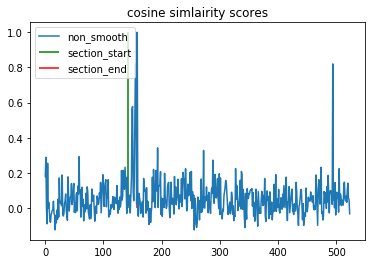

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.png


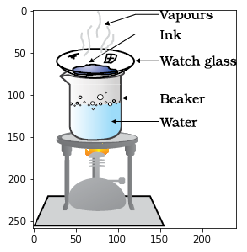

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.json
~~~~~~~ Labels  ~~~~~~~~
-Vapours -Ink
-Watch glass
-Beaker -Water
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.1 How can we obtain coloured component (dye) from blue/black ink?
fig caption =  Fig. 2.5: Evaporation
below header =  Now answer
Fig caption sentence =  Figure 2.5: Evaporation. This figure contains Vapours Ink, Watch glass, Beaker Water.


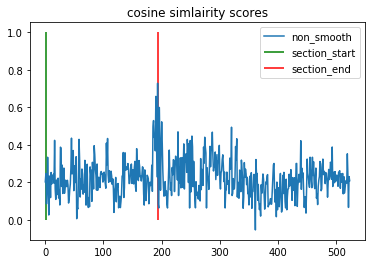

------- fig  5   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.png


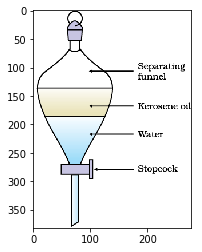

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.json
~~~~~~~ Labels  ~~~~~~~~
Separating funnel
Kerosene oil
Water
Stopcock
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.3 How can we separate a mixture of two immiscible liquids?
fig caption =  Fig. 2.6: Separation of immiscible liquids
below header =  Applications
Fig caption sentence =  Figure 2.6: Separation of immiscible liquids. This figure contains Separating funnel, Kerosene oil, Water, Stopcock.


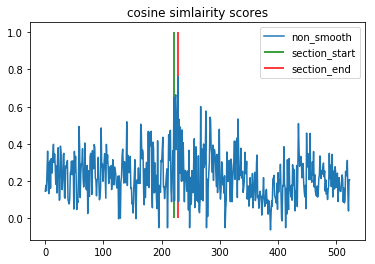

------- fig  6   --------
fig + parent
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.png


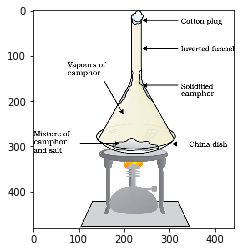

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.json
~~~~~~~ Labels  ~~~~~~~~
Cotton plug
Inverted funnel
Vapours of camphor
Solidified camphor
Mixture of camphor and salt
-China dish
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.4 How can we separate a mixture of salt and camphor?
fig caption =  Fig. 2.7: Separation of camphor and salt by sublimation
below header =  2.3.5 Is the dye in black ink a single colour?
Fig caption sentence =  Figure 2.7: Separation of camphor and salt by sublimation. This figure contains Cotton plug, Inverted funnel, Vapours of camphor, Solidified camphor, Mixture of camphor and salt, China dish.


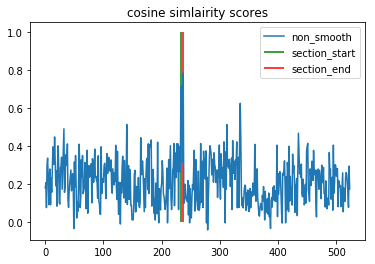

------- fig  7   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.png


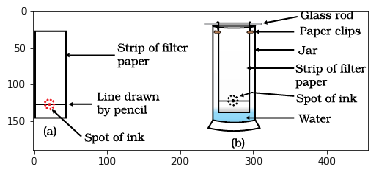

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.json
~~~~~~~ Labels  ~~~~~~~~
Strip of filter paper
Glass rod Paper clips Jar -Strip of filter paper Spot of ink - Water
Line drawn by pencil
( a )
Spot of ink
( b )
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.5 Is the dye in black ink a single colour?
fig caption =  Fig. 2.8: Separation of dyes in black ink using
below header =  Now answer
Fig caption sentence =  Figure 2.8: Separation of dyes in black ink using. This figure contains Strip of filter paper, Glass rod Paper clips Jar Strip of filter paper Spot of ink  Water, Line drawn by pencil, ( a ), Spot of ink, ( b ).
!!!!! ERROR !!!!
start index of section =  238
end index of section =  246
indices of section =  [238, 239, 240, 241, 242, 243, 244, 245, 246]
len of matched sent =  9
len of section sent =  11
!!!!! ERROR !!!!
start index of section =  238
end index of section =  246
indices of section =  [238, 239, 240, 241, 242, 243

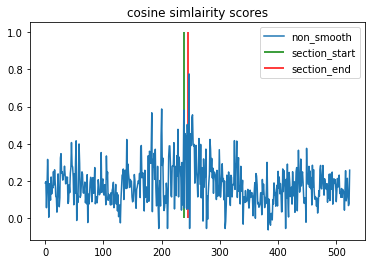

!!!!! ERROR !!!!
start index of section =  238
end index of section =  246
indices of section =  [238, 239, 240, 241, 242, 243, 244, 245, 246]
len of matched sent =  9
len of section sent =  11
!!!!! ERROR !!!!
start index of section =  238
end index of section =  246
indices of section =  [238, 239, 240, 241, 242, 243, 244, 245, 246]
len of matched sent =  9
len of section sent =  11
------- fig  8   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.png


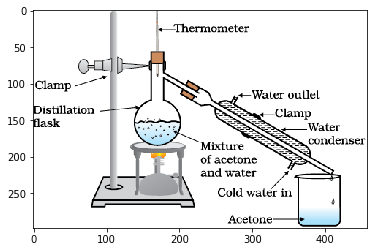

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.json
~~~~~~~ Labels  ~~~~~~~~
-Thermometer
Clamp
Distillation flask
-Water outlet -Clamp -Water Mixture condenser of acetone and water Cold water in
Acetone
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.6 How can we separate a mixture of two miscible liquids?
fig caption =  Fig.2.9: Separation of two miscible liquids by distillation
below header =  Now answer
Fig caption sentence =  Fig.2.9: Separation of two miscible liquids by distillation. This figure contains Thermometer, Clamp, Distillation flask, Water outlet Clamp Water Mixture condenser of acetone and water Cold water in, Acetone.


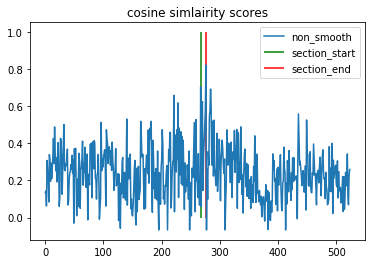

------- fig  9   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.png


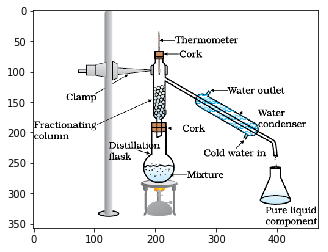

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.json
~~~~~~~ Labels  ~~~~~~~~
- Thermometer -Cork
-Water outlet
Clamp
-Water condenser
Fractionating column
-Cork
Distillation flask
Cold water in
-Mixture
< >
Pure liquid component
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  Now answer
fig caption =  Fig. 2.10: Fractional distillation
below header =  2.3.7 How can we obtain different gases from air ?
Fig caption sentence =  Figure 2.10: Fractional distillation. This figure contains  Thermometer Cork, Water outlet, Clamp, Water condenser, Fractionating column, Cork, Distillation flask, Cold water in, Mixture, < >, Pure liquid component.
!!!!! ERROR !!!!
start index of section =  279
end index of section =  288
indices of section =  [279, 280, 281, 282, 283, 284, 285, 286, 287, 288]
len of matched sent =  10
len of section sent =  11
!!!!! ERROR !!!!
start index of section =  279
end index of section =  288
indices of section =  [279, 280, 2

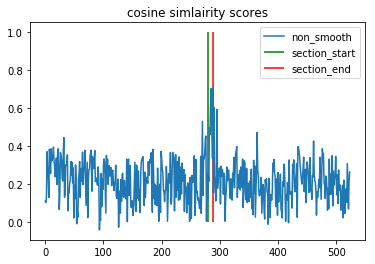

!!!!! ERROR !!!!
start index of section =  279
end index of section =  288
indices of section =  [279, 280, 281, 282, 283, 284, 285, 286, 287, 288]
len of matched sent =  10
len of section sent =  11
!!!!! ERROR !!!!
start index of section =  279
end index of section =  288
indices of section =  [279, 280, 281, 282, 283, 284, 285, 286, 287, 288]
len of matched sent =  10
len of section sent =  11
------- fig  10   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.png


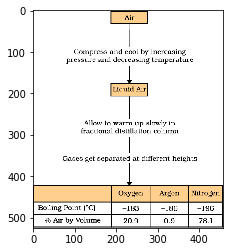

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.json
~~~~~~~ Labels  ~~~~~~~~
Air
Compress and cool by increasing pressure and decreasing temperature
Liquid Air
Allow to warm up slowly in fractional distillation column
Gases get separated at different heights
Oxygen
Argon
Nitrogen
-183
-186
-196
Boiling Point ( ° C ) % Air by Volume
20.9
0.9
78.1
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.11: Flow diagram shows the process of obtaining gases from air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  Figure 2.11: Flow diagram shows the process of obtaining gases from air. This figure contains Air, Compress and cool by increasing pressure and decreasing temperature, Liquid Air, Allow to warm up slowly in fractional distillation column, Gases get separated at different heights, Oxygen, Argon, Nitrogen, 183, 186

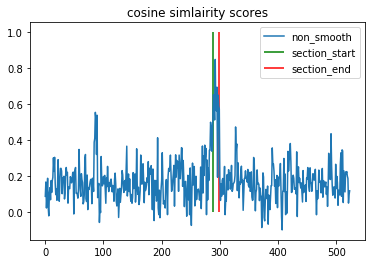

------- fig  11   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.png


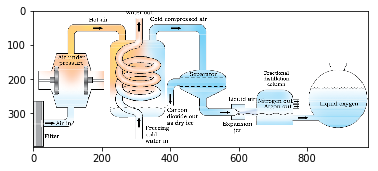

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.json
~~~~~~~ Labels  ~~~~~~~~
Water out Cold compressed air
Hot air
Air under pressure
000
Separator
Fractional distillation column
Liquid air Nitrogen out Argon out
Liquid oxygen
Air in
Carbon dioxide out as dry ice Freezing cold water in
Expansion jet
Filter
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.12: Separation of components of air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  Figure 2.12: Separation of components of air. This figure contains Water out Cold compressed air, Hot air, Air under pressure, 000, Separator, Fractional distillation column, Liquid air Nitrogen out Argon out, Liquid oxygen, Air in, Carbon dioxide out as dry ice Freezing cold water in, Expansion jet, Filter.


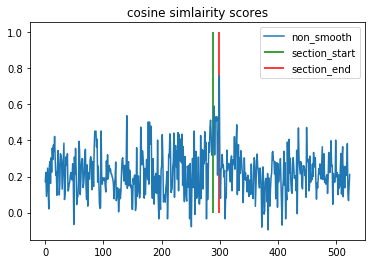

------- fig  12   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.png


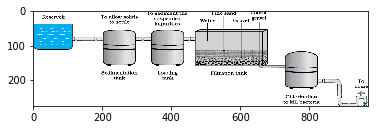

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.json
~~~~~~~ Labels  ~~~~~~~~
Coarse
Reservoir
To allow solids to settle
To sediment the suspended impurities
Fine sand Water
Gravel gravel
COM
Sedimentation tank
Loading tank
Filtration tank
To home
Chlorination to kill bacteria
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  Applications
fig caption =  Fig. 2.13: Water purification system in water works
below header =  Questions
Fig caption sentence =  Figure 2.13: Water purification system in water works. This figure contains Coarse, Reservoir, To allow solids to settle, To sediment the suspended impurities, Fine sand Water, Gravel gravel, COM, Sedimentation tank, Loading tank, Filtration tank, To home, Chlorination to kill bacteria.
!!!!! ERROR !!!!
start index of section =  323
end index of section =  329
indices of section =  [323, 324, 325, 326, 327, 328, 329]
len of matched sent =  7
len of section sent =  8
!!!!! ERROR !!!!
start index

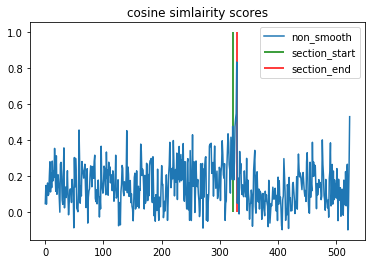

!!!!! ERROR !!!!
start index of section =  323
end index of section =  329
indices of section =  [323, 324, 325, 326, 327, 328, 329]
len of matched sent =  7
len of section sent =  8
!!!!! ERROR !!!!
start index of section =  323
end index of section =  329
indices of section =  [323, 324, 325, 326, 327, 328, 329]
len of matched sent =  7
len of section sent =  8


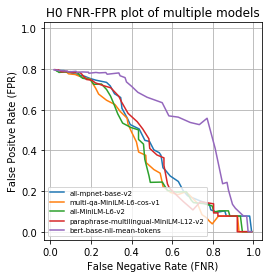

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.png


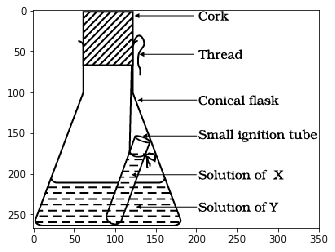

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.json
~~~~~~~ Labels  ~~~~~~~~
Cork
Thread
-Conical flask
-Small ignition tube
Solution of X
Solution of Y
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.1.1 Law of conservation of mass
fig caption =  Fig. 3.1: Ignition tube containing solution of X, dipped in a conical flask containing solution of Y.
below header =  3.1.2 Law of constant proportions
Fig caption sentence =  Figure 3.1: Ignition tube containing solution of X, dipped in a conical flask containing solution of Y.. This figure contains Cork, Thread, Conical flask, Small ignition tube, Solution of X, Solution of Y.


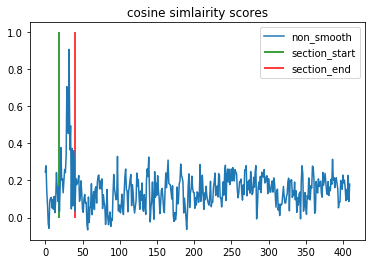

------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.2_fmt.jpeg


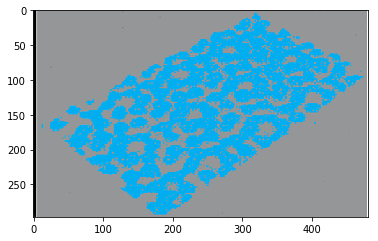

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.2 What is an Atom?
fig caption =  Fig. 3.2: An image of the surface of silicon
below header =  3.2.1 What are the modern day symbols of atoms of different elements?
Fig caption sentence =  Figure 3.2: An image of the surface of silicon


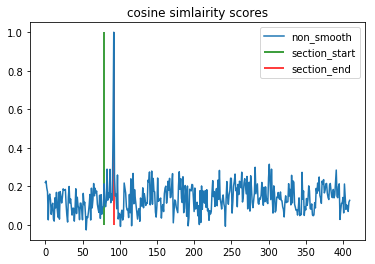

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.png


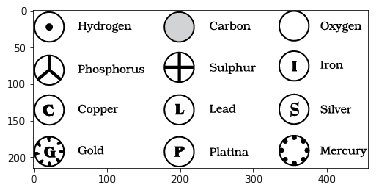

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.json
~~~~~~~ Labels  ~~~~~~~~
Hydrogen
Carbon
Oxygen
Phosphorus
Sulphur
I ) Iron
c
Copper
L
Lead
S Silver
G
Gold
P
Platina
Mercury
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.2.1 What are the modern day symbols of atoms of different elements?
fig caption =  Fig. 3.3: Symbols for some elements as proposed by Dalton
below header =  For example
Fig caption sentence =  Figure 3.3: Symbols for some elements as proposed by Dalton. This figure contains Hydrogen, Carbon, Oxygen, Phosphorus, Sulphur, I ) Iron, c, Copper, L, Lead, S Silver, G, Gold, P, Platina, Mercury.


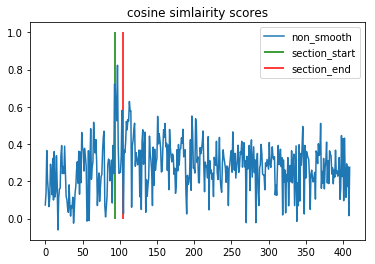

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.png


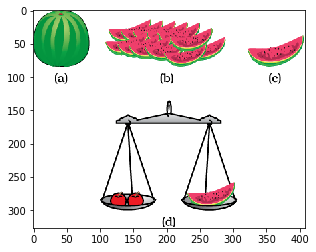

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.json
~~~~~~~ Labels  ~~~~~~~~
( a )
( b )
( c )
( d )
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.2.2 Atomic mass
fig caption =  Fig. 3.4 : (a) Watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon
below header =  3.2.3 How do atoms exist?
Fig caption sentence =  Figure 3.4 : (a) Watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon. This figure contains ( a ), ( b ), ( c ), ( d ).


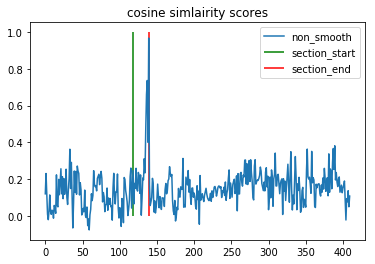

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.png


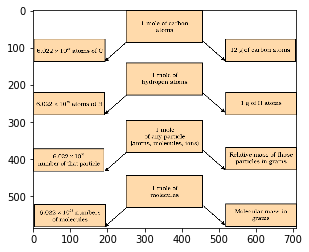

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.json
~~~~~~~ Labels  ~~~~~~~~
1 mole of carbon atoms
6.022 x 10 " atoms of C
12 g of carbon atoms
1 mole of hydrogen atoms
6.022 x 10 ” atoms of H
1 g of H atoms
1 mole of any particle ( atoms , molecules , ions )
6.022 x 10 number of that particle
Relative mass of those particles in grams
1 mole of molecules
6.022 x 102 numbers of molecules
Molecular mass in grams
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.5.3 Mole concept
fig caption =  Fig. 3.5: Relationship between mole, Avogadro number and mass
below header =  Questions
Fig caption sentence =  Figure 3.5: Relationship between mole, Avogadro number and mass. This figure contains 1 mole of carbon atoms, 6.022 x 10 " atoms of C, 12 g of carbon atoms, 1 mole of hydrogen atoms, 6.022 x 10   atoms of H, 1 g of H atoms, 1 mole of any particle ( atoms , molecules , ions ), 6.022 x 10 number of that particle, Relative mass of those particles

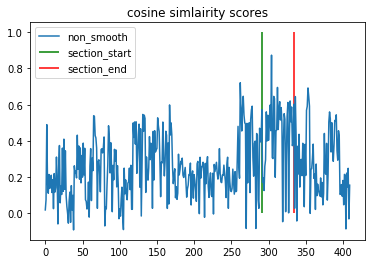

!!!!! ERROR !!!!
start index of section =  291
end index of section =  334
indices of section =  [291, 292, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 309, 310, 311, 312, 313, 314, 315, 316, 317, 319, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333, 334]
len of matched sent =  38
len of section sent =  44
!!!!! ERROR !!!!
start index of section =  291
end index of section =  334
indices of section =  [291, 292, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 309, 310, 311, 312, 313, 314, 315, 316, 317, 319, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333, 334]
len of matched sent =  38
len of section sent =  44


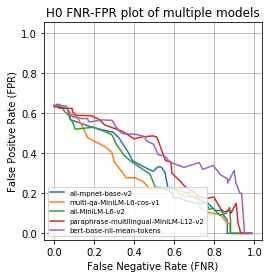

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.png


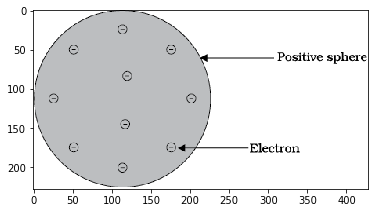

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.json
~~~~~~~ Labels  ~~~~~~~~
Positive sphere
-Electron
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.2.1 Thomson’s model of an atom
fig caption =  Fig.4.1: Thomson s model of an atom
below header =  4.2.2 Rutherford’s model of an atom
Fig caption sentence =  Fig.4.1: Thomson s model of an atom. This figure contains Positive sphere, Electron.


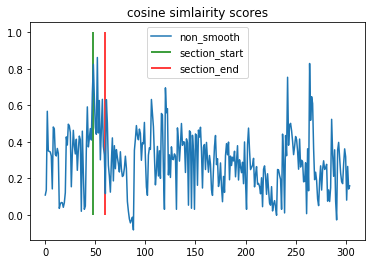

------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.png


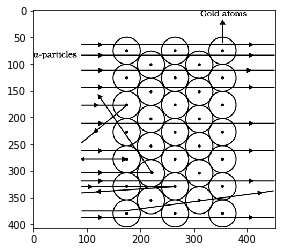

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.json
~~~~~~~ Labels  ~~~~~~~~
Gold atoms
a - particles
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.2.2 Rutherford’s model of an atom
fig caption =  Fig. 4.2: Scattering of  -particles by a gold foil
below header =  Drawbacks of Rutherford’s model of the atom
Fig caption sentence =  Figure 4.2: Scattering of  -particles by a gold foil. This figure contains Gold atoms, a  particles.


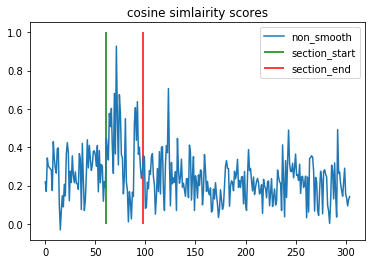

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.png


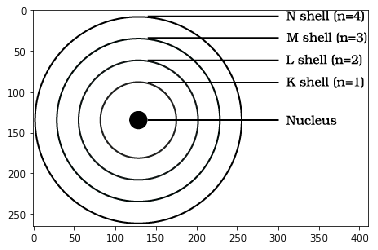

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.json
~~~~~~~ Labels  ~~~~~~~~
N shell ( n = 4 ) M shell ( n = 3 ) L shell ( n = 2 ) K shell ( n = 1 )
Nucleus
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.2.3 Bohr’s model of atom
fig caption =  Fig. 4.3: A few energy levels in an atom
below header =  Questions
Fig caption sentence =  Figure 4.3: A few energy levels in an atom. This figure contains N shell ( n = 4 ) M shell ( n = 3 ) L shell ( n = 2 ) K shell ( n = 1 ), Nucleus.


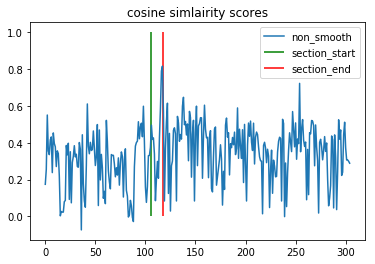

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.png


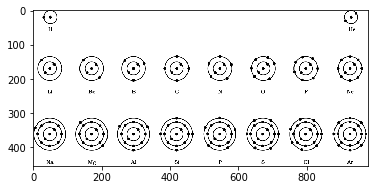

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.json
~~~~~~~ Labels  ~~~~~~~~
Q
H
He
Q
o
Li
Be
B
N
F
Ne
Na
Mg
Al
Si
P
S
CI
Ar
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.3 How are Electrons Distributed in Different Orbits (Shells)?
fig caption =  Fig.4.4: Schematic atomic structure of the first eighteen elements
below header =  Questions
Fig caption sentence =  Fig.4.4: Schematic atomic structure of the first eighteen elements. This figure contains Q, H, He, Q, o, Li, Be, B, N, F, Ne, Na, Mg, Al, Si, P, S, CI, Ar.
!!!!! ERROR !!!!
start index of section =  135
end index of section =  148
indices of section =  [135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148]
len of matched sent =  13
len of section sent =  14
!!!!! ERROR !!!!
start index of section =  135
end index of section =  148
indices of section =  [135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148]
len of matched sent =  13
len of section sent =  14

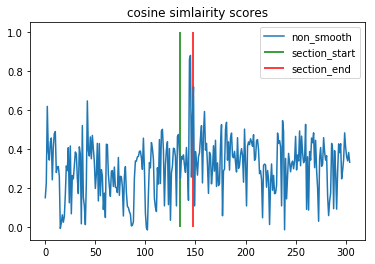

!!!!! ERROR !!!!
start index of section =  135
end index of section =  148
indices of section =  [135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148]
len of matched sent =  13
len of section sent =  14
!!!!! ERROR !!!!
start index of section =  135
end index of section =  148
indices of section =  [135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148]
len of matched sent =  13
len of section sent =  14


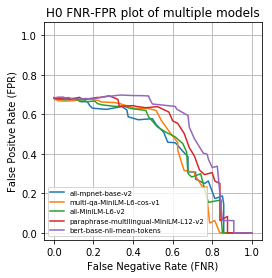

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

***************  Error while opening file   ***************
./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml
************************************************************
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
 ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^
I/O operation on closed file.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png


FileNotFoundError: [Errno 2] No such file or directory: './data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png'

In [ ]:
# ----------------------- Heuristic 0 -------------------------------
# Consider few sentences above and below the fig as boundary.
# Next, consider similar sentence with in the boundary as similar sentences.
# -------------------------------------------------------------------

# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
# papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']
papers_html_files =[]

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

no_bounding_sent = 30
no_points_fpr_fnr_plot = 50

debug = 0

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True
# if smooth_true:
# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]
# else:
#     smooth_no_list = [0]

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in filenames_list:
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)

            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in all_fig:
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)

                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

                    if len(sect_index_list) != len(sent_list):
                        print("!!!!! ERROR !!!!")
                        print("start index of section = ",sect_index_list[0])
                        print("end index of section = ",sect_index_list[-1])
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    cosine_threshold_list = np.arange(0.0, 1.0001 ,(1/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)

                    fpr_fnr_list_threshold = []
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value >= cosine_threshold and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value >= cosine_threshold:
                                    prediction_index_list.append(index)
                        no_sim_sent = len(prediction_index_list)
                        for index in prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H0 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H0 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/h0_"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/h0_'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H0 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H0 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h0_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h0_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H0 FNR-FPR plot of multiple smoothing of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h0_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# test: all models accuracy test with heuristic 1

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.png


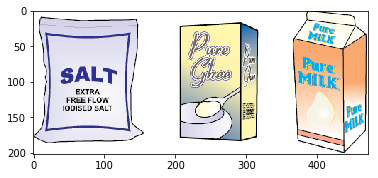

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/867.json
~~~~~~~ Labels  ~~~~~~~~
Pure MILK
Pure Ghee
SALT
Pure MILK
EXTRA FREE FLOW IODISED SALT
Pure
MILK
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  Is Matter Around Us Pure?
fig caption =  Fig. 2.1: Some consumable items
below header =  2.1 What is a Mixture?
Fig caption sentence =  Figure 2.1: Some consumable items. This figure contains Pure MILK, Pure Ghee, SALT, Pure MILK, EXTRA FREE FLOW IODISED SALT, Pure, MILK.
index of caption in all_sent_list =  4
width of boundary =  30
indices of section =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
len of matched sent =  12
len of section sent =  12


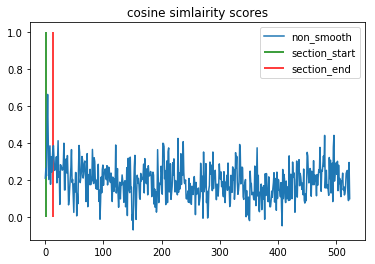

------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.png


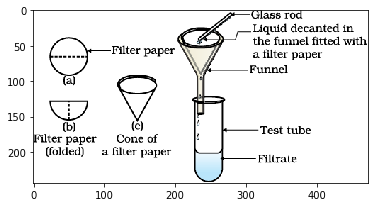

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/877.json
~~~~~~~ Labels  ~~~~~~~~
-Filter paper
-Glass rod Liquid decanted in the funnel fitted with a filter paper - Funnel
-Test tube
( b ) ( c ) Filter paper Cone of ( folded ) a filter paper
10
-Filtrate
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.1.1 Types of mixtures
fig caption =  Fig. 2.2: Filtration
below header =  Questions
Fig caption sentence =  Figure 2.2: Filtration. This figure contains Filter paper, Glass rod Liquid decanted in the funnel fitted with a filter paper  Funnel, Test tube, ( b ) ( c ) Filter paper Cone of ( folded ) a filter paper, 10, Filtrate.
index of caption in all_sent_list =  58
width of boundary =  30
indices of section =  [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
len of matched sent =  38
len of section sent =  38


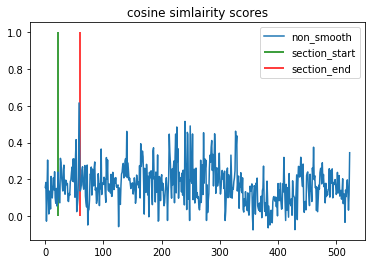

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.png


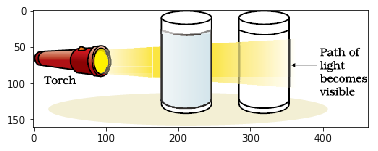

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/977.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.3: (a) Solution of copper sulphate does not show
below header =  Properties of a colloid
Fig caption sentence =  Figure 2.3: (a) Solution of copper sulphate does not show
index of caption in all_sent_list =  153
width of boundary =  30
indices of section =  [142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
len of matched sent =  17
len of section sent =  17


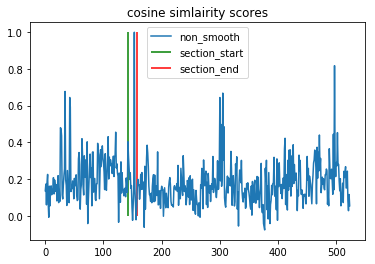

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.4_fmt.jpeg


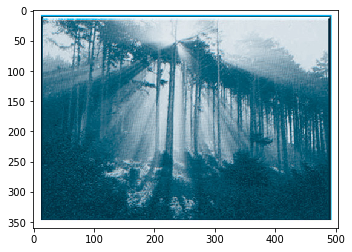

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/2.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.2.3 What is a colloidal solution?
fig caption =  Fig. 2.4: The Tyndall effect
below header =  Properties of a colloid
Fig caption sentence =  Figure 2.4: The Tyndall effect
index of caption in all_sent_list =  158
width of boundary =  30
indices of section =  [142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
len of matched sent =  17
len of section sent =  17


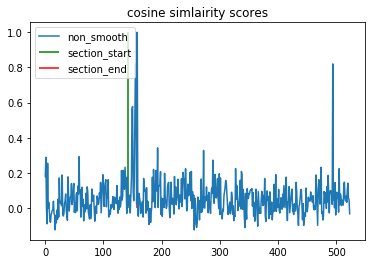

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.png


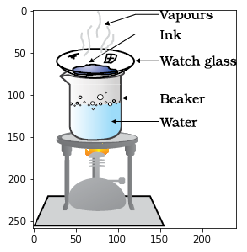

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1036.json
~~~~~~~ Labels  ~~~~~~~~
-Vapours -Ink
-Watch glass
-Beaker -Water
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.1 How can we obtain coloured component (dye) from blue/black ink?
fig caption =  Fig. 2.5: Evaporation
below header =  Now answer
Fig caption sentence =  Figure 2.5: Evaporation. This figure contains Vapours Ink, Watch glass, Beaker Water.
index of caption in all_sent_list =  193
width of boundary =  30
indices of section =  [2, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193]
len of matched sent =  12
len of section sent =  12


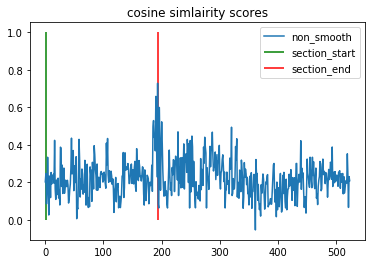

------- fig  5   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.png


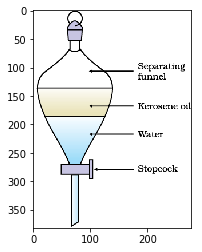

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1118.json
~~~~~~~ Labels  ~~~~~~~~
Separating funnel
Kerosene oil
Water
Stopcock
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.3 How can we separate a mixture of two immiscible liquids?
fig caption =  Fig. 2.6: Separation of immiscible liquids
below header =  Applications
Fig caption sentence =  Figure 2.6: Separation of immiscible liquids. This figure contains Separating funnel, Kerosene oil, Water, Stopcock.
index of caption in all_sent_list =  228
width of boundary =  30
indices of section =  [221, 222, 223, 224, 225, 226, 227, 228]
len of matched sent =  8
len of section sent =  8


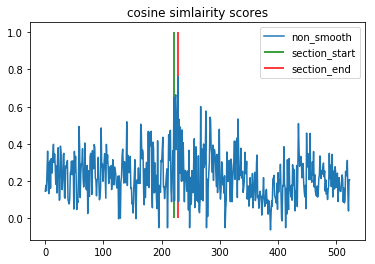

------- fig  6   --------
fig + parent
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.png


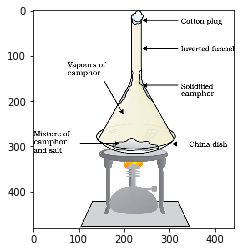

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1128.json
~~~~~~~ Labels  ~~~~~~~~
Cotton plug
Inverted funnel
Vapours of camphor
Solidified camphor
Mixture of camphor and salt
-China dish
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.4 How can we separate a mixture of salt and camphor?
fig caption =  Fig. 2.7: Separation of camphor and salt by sublimation
below header =  2.3.5 Is the dye in black ink a single colour?
Fig caption sentence =  Figure 2.7: Separation of camphor and salt by sublimation. This figure contains Cotton plug, Inverted funnel, Vapours of camphor, Solidified camphor, Mixture of camphor and salt, China dish.
index of caption in all_sent_list =  237
width of boundary =  30
indices of section =  [233, 234, 235, 236, 237]
len of matched sent =  5
len of section sent =  5


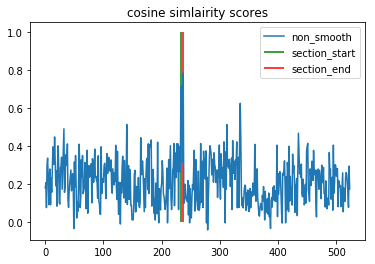

------- fig  7   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.png


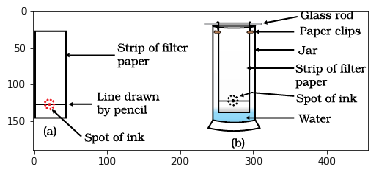

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1165.json
~~~~~~~ Labels  ~~~~~~~~
Strip of filter paper
Glass rod Paper clips Jar -Strip of filter paper Spot of ink - Water
Line drawn by pencil
( a )
Spot of ink
( b )
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.5 Is the dye in black ink a single colour?
fig caption =  Fig. 2.8: Separation of dyes in black ink using
below header =  Now answer
Fig caption sentence =  Figure 2.8: Separation of dyes in black ink using. This figure contains Strip of filter paper, Glass rod Paper clips Jar Strip of filter paper Spot of ink  Water, Line drawn by pencil, ( a ), Spot of ink, ( b ).
index of caption in all_sent_list =  -1
width of boundary =  30
indices of section =  [238, 239, 240, 241, 242, 243, 244, 245, 246]
len of matched sent =  9
len of section sent =  11


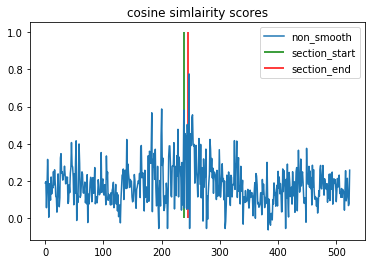

------- fig  8   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.png


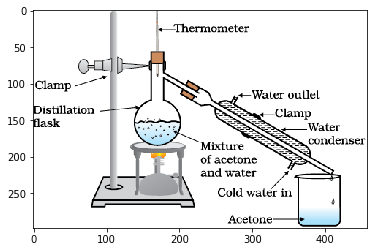

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1150.json
~~~~~~~ Labels  ~~~~~~~~
-Thermometer
Clamp
Distillation flask
-Water outlet -Clamp -Water Mixture condenser of acetone and water Cold water in
Acetone
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.6 How can we separate a mixture of two miscible liquids?
fig caption =  Fig.2.9: Separation of two miscible liquids by distillation
below header =  Now answer
Fig caption sentence =  Fig.2.9: Separation of two miscible liquids by distillation. This figure contains Thermometer, Clamp, Distillation flask, Water outlet Clamp Water Mixture condenser of acetone and water Cold water in, Acetone.
index of caption in all_sent_list =  276
width of boundary =  30
indices of section =  [267, 268, 269, 270, 271, 272, 273, 274, 275, 276]
len of matched sent =  10
len of section sent =  10


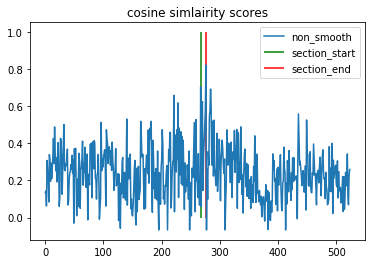

------- fig  9   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.png


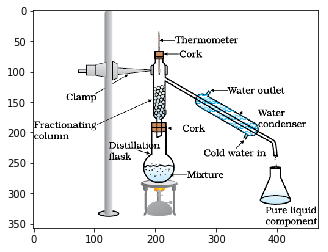

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1223.json
~~~~~~~ Labels  ~~~~~~~~
- Thermometer -Cork
-Water outlet
Clamp
-Water condenser
Fractionating column
-Cork
Distillation flask
Cold water in
-Mixture
< >
Pure liquid component
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  Now answer
fig caption =  Fig. 2.10: Fractional distillation
below header =  2.3.7 How can we obtain different gases from air ?
Fig caption sentence =  Figure 2.10: Fractional distillation. This figure contains  Thermometer Cork, Water outlet, Clamp, Water condenser, Fractionating column, Cork, Distillation flask, Cold water in, Mixture, < >, Pure liquid component.
index of caption in all_sent_list =  288
width of boundary =  30
indices of section =  [279, 280, 281, 282, 283, 284, 285, 286, 287, 288]
len of matched sent =  10
len of section sent =  11


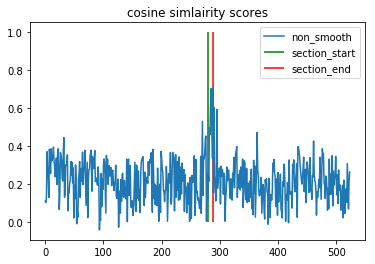

------- fig  10   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.png


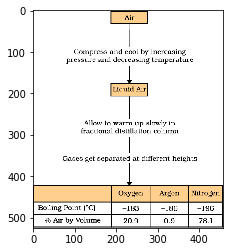

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1237.json
~~~~~~~ Labels  ~~~~~~~~
Air
Compress and cool by increasing pressure and decreasing temperature
Liquid Air
Allow to warm up slowly in fractional distillation column
Gases get separated at different heights
Oxygen
Argon
Nitrogen
-183
-186
-196
Boiling Point ( ° C ) % Air by Volume
20.9
0.9
78.1
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.11: Flow diagram shows the process of obtaining gases from air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  Figure 2.11: Flow diagram shows the process of obtaining gases from air. This figure contains Air, Compress and cool by increasing pressure and decreasing temperature, Liquid Air, Allow to warm up slowly in fractional distillation column, Gases get separated at different heights, Oxygen, Argon, Nitrogen, 183, 186

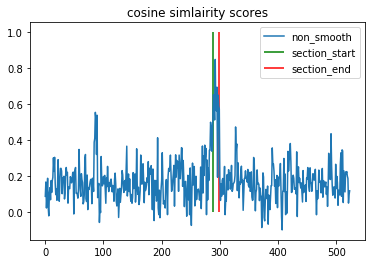

------- fig  11   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.png


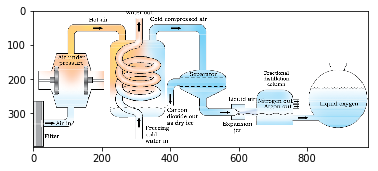

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1198.json
~~~~~~~ Labels  ~~~~~~~~
Water out Cold compressed air
Hot air
Air under pressure
000
Separator
Fractional distillation column
Liquid air Nitrogen out Argon out
Liquid oxygen
Air in
Carbon dioxide out as dry ice Freezing cold water in
Expansion jet
Filter
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  2.3.7 How can we obtain different gases from air ?
fig caption =  Fig. 2.12: Separation of components of air
below header =  2.3.8 How can we obtain pure copper sulphate from an impure sample?
Fig caption sentence =  Figure 2.12: Separation of components of air. This figure contains Water out Cold compressed air, Hot air, Air under pressure, 000, Separator, Fractional distillation column, Liquid air Nitrogen out Argon out, Liquid oxygen, Air in, Carbon dioxide out as dry ice Freezing cold water in, Expansion jet, Filter.
index of caption in all_sent_list =  299
width of boundary =  30
indice

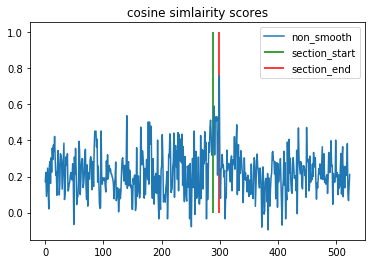

------- fig  12   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.png


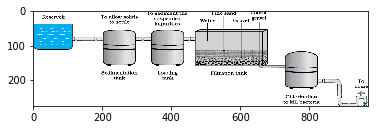

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Images/1290.json
~~~~~~~ Labels  ~~~~~~~~
Coarse
Reservoir
To allow solids to settle
To sediment the suspended impurities
Fine sand Water
Gravel gravel
COM
Sedimentation tank
Loading tank
Filtration tank
To home
Chlorination to kill bacteria
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  Applications
fig caption =  Fig. 2.13: Water purification system in water works
below header =  Questions
Fig caption sentence =  Figure 2.13: Water purification system in water works. This figure contains Coarse, Reservoir, To allow solids to settle, To sediment the suspended impurities, Fine sand Water, Gravel gravel, COM, Sedimentation tank, Loading tank, Filtration tank, To home, Chlorination to kill bacteria.
index of caption in all_sent_list =  329
width of boundary =  30
indices of section =  [323, 324, 325, 326, 327, 328, 329]
len of matched sent =  7
len of section sent =  8


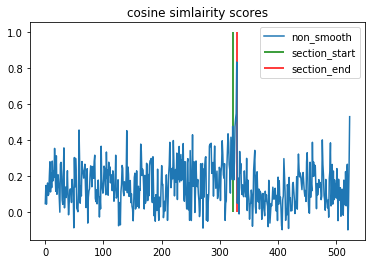

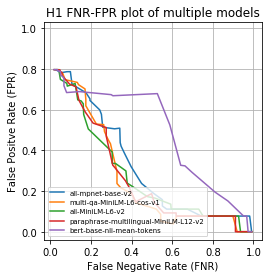

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.png


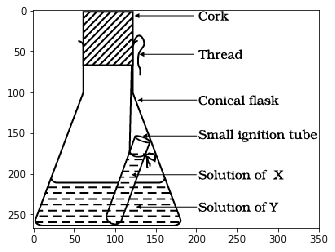

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/695.json
~~~~~~~ Labels  ~~~~~~~~
Cork
Thread
-Conical flask
-Small ignition tube
Solution of X
Solution of Y
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.1.1 Law of conservation of mass
fig caption =  Fig. 3.1: Ignition tube containing solution of X, dipped in a conical flask containing solution of Y.
below header =  3.1.2 Law of constant proportions
Fig caption sentence =  Figure 3.1: Ignition tube containing solution of X, dipped in a conical flask containing solution of Y.. This figure contains Cork, Thread, Conical flask, Small ignition tube, Solution of X, Solution of Y.
index of caption in all_sent_list =  32
width of boundary =  30
indices of section =  [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
len of matched sent =  23
len of section sent =  23


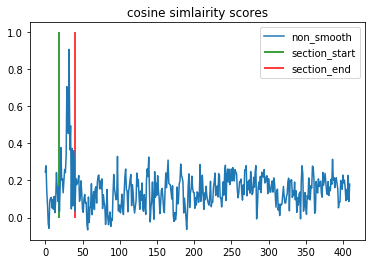

------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.2_fmt.jpeg


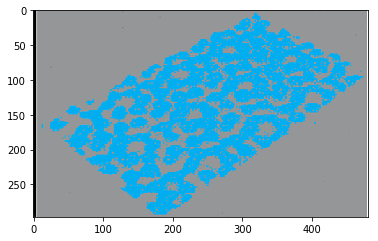

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/3.json
~~~~~~~ Labels  ~~~~~~~~
  NO Labels  
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.2 What is an Atom?
fig caption =  Fig. 3.2: An image of the surface of silicon
below header =  3.2.1 What are the modern day symbols of atoms of different elements?
Fig caption sentence =  Figure 3.2: An image of the surface of silicon
index of caption in all_sent_list =  92
width of boundary =  30
indices of section =  [79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
len of matched sent =  14
len of section sent =  14


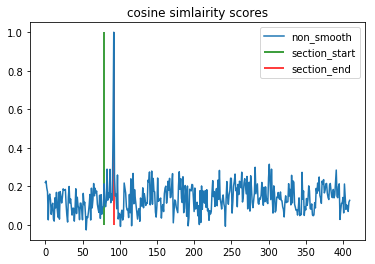

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.png


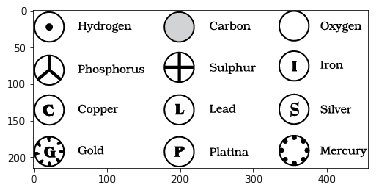

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/779.json
~~~~~~~ Labels  ~~~~~~~~
Hydrogen
Carbon
Oxygen
Phosphorus
Sulphur
I ) Iron
c
Copper
L
Lead
S Silver
G
Gold
P
Platina
Mercury
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.2.1 What are the modern day symbols of atoms of different elements?
fig caption =  Fig. 3.3: Symbols for some elements as proposed by Dalton
below header =  For example
Fig caption sentence =  Figure 3.3: Symbols for some elements as proposed by Dalton. This figure contains Hydrogen, Carbon, Oxygen, Phosphorus, Sulphur, I ) Iron, c, Copper, L, Lead, S Silver, G, Gold, P, Platina, Mercury.
index of caption in all_sent_list =  97
width of boundary =  30
indices of section =  [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
len of matched sent =  12
len of section sent =  12


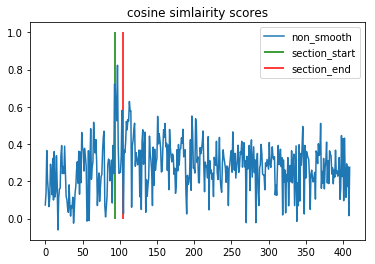

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.png


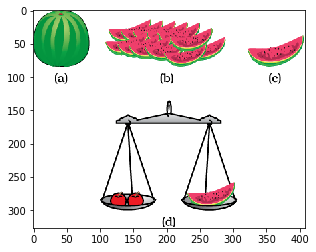

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/856.json
~~~~~~~ Labels  ~~~~~~~~
( a )
( b )
( c )
( d )
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.2.2 Atomic mass
fig caption =  Fig. 3.4 : (a) Watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon
below header =  3.2.3 How do atoms exist?
Fig caption sentence =  Figure 3.4 : (a) Watermelon, (b) 12 pieces, (c) 1/12 of watermelon, (d) how the fruit seller can weigh the fruits using pieces of watermelon. This figure contains ( a ), ( b ), ( c ), ( d ).
index of caption in all_sent_list =  139
width of boundary =  30
indices of section =  [118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]
len of matched sent =  22
len of section sent =  22


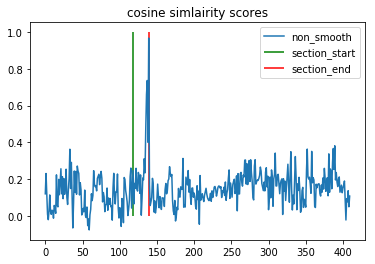

------- fig  4   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.png


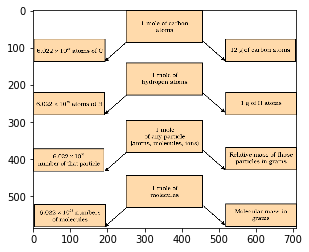

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Images/1068.json
~~~~~~~ Labels  ~~~~~~~~
1 mole of carbon atoms
6.022 x 10 " atoms of C
12 g of carbon atoms
1 mole of hydrogen atoms
6.022 x 10 ” atoms of H
1 g of H atoms
1 mole of any particle ( atoms , molecules , ions )
6.022 x 10 number of that particle
Relative mass of those particles in grams
1 mole of molecules
6.022 x 102 numbers of molecules
Molecular mass in grams
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  3.5.3 Mole concept
fig caption =  Fig. 3.5: Relationship between mole, Avogadro number and mass
below header =  Questions
Fig caption sentence =  Figure 3.5: Relationship between mole, Avogadro number and mass. This figure contains 1 mole of carbon atoms, 6.022 x 10 " atoms of C, 12 g of carbon atoms, 1 mole of hydrogen atoms, 6.022 x 10   atoms of H, 1 g of H atoms, 1 mole of any particle ( atoms , molecules , ions ), 6.022 x 10 number of that particle, Relative mass of those particles

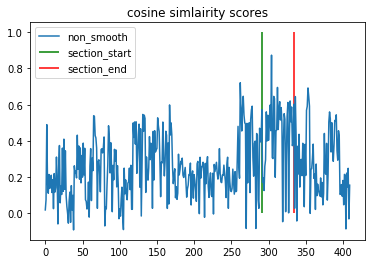

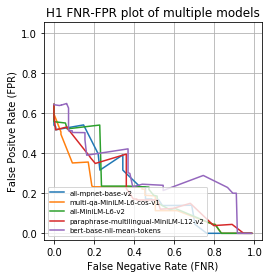

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

++++++++++++++++++++++++++++   START   +++++++++++++++++++++
./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.png


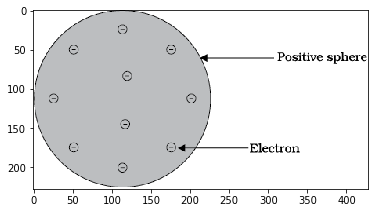

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/836.json
~~~~~~~ Labels  ~~~~~~~~
Positive sphere
-Electron
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.2.1 Thomson’s model of an atom
fig caption =  Fig.4.1: Thomson s model of an atom
below header =  4.2.2 Rutherford’s model of an atom
Fig caption sentence =  Fig.4.1: Thomson s model of an atom. This figure contains Positive sphere, Electron.
index of caption in all_sent_list =  52
width of boundary =  30
indices of section =  [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
len of matched sent =  13
len of section sent =  13


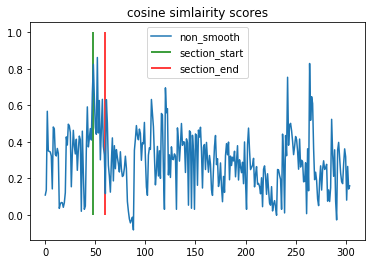

------- fig  1   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.png


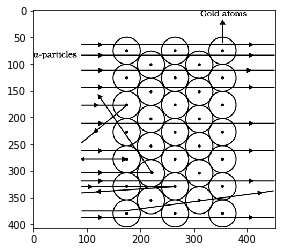

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/998.json
~~~~~~~ Labels  ~~~~~~~~
Gold atoms
a - particles
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.2.2 Rutherford’s model of an atom
fig caption =  Fig. 4.2: Scattering of  -particles by a gold foil
below header =  Drawbacks of Rutherford’s model of the atom
Fig caption sentence =  Figure 4.2: Scattering of  -particles by a gold foil. This figure contains Gold atoms, a  particles.
index of caption in all_sent_list =  71
width of boundary =  30
indices of section =  [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
len of matched sent =  38
len of section sent =  38


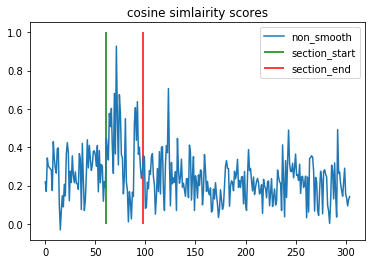

------- fig  2   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.png


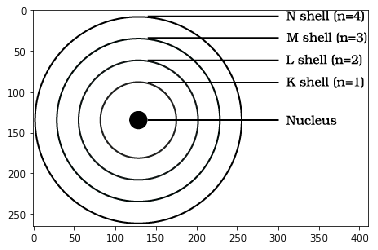

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/969.json
~~~~~~~ Labels  ~~~~~~~~
N shell ( n = 4 ) M shell ( n = 3 ) L shell ( n = 2 ) K shell ( n = 1 )
Nucleus
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.2.3 Bohr’s model of atom
fig caption =  Fig. 4.3: A few energy levels in an atom
below header =  Questions
Fig caption sentence =  Figure 4.3: A few energy levels in an atom. This figure contains N shell ( n = 4 ) M shell ( n = 3 ) L shell ( n = 2 ) K shell ( n = 1 ), Nucleus.
index of caption in all_sent_list =  117
width of boundary =  30
indices of section =  [106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
len of matched sent =  13
len of section sent =  13


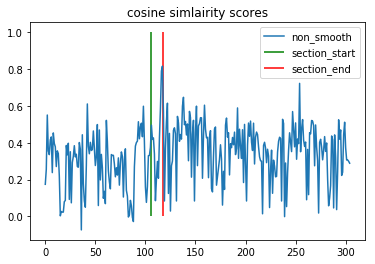

------- fig  3   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.png


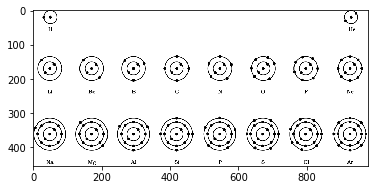

    Json already exist :  ./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Images/1091.json
~~~~~~~ Labels  ~~~~~~~~
Q
H
He
Q
o
Li
Be
B
N
F
Ne
Na
Mg
Al
Si
P
S
CI
Ar
~~~~~~~~~~~~~~~~~~~~~~~~

above header =  4.3 How are Electrons Distributed in Different Orbits (Shells)?
fig caption =  Fig.4.4: Schematic atomic structure of the first eighteen elements
below header =  Questions
Fig caption sentence =  Fig.4.4: Schematic atomic structure of the first eighteen elements. This figure contains Q, H, He, Q, o, Li, Be, B, N, F, Ne, Na, Mg, Al, Si, P, S, CI, Ar.
index of caption in all_sent_list =  145
width of boundary =  30
indices of section =  [135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148]
len of matched sent =  13
len of section sent =  14


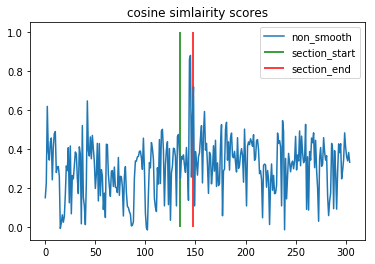

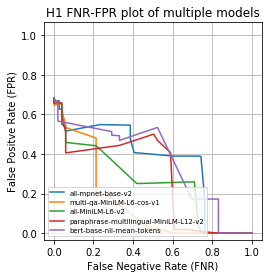

++++++++++++++++++++++++++++   END   +++++++++++++++++++++

***************  Error while opening file   ***************
./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml
************************************************************
@@@@@@@@@@@@   XML parser @@@@@@@@@@@@
 ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^
I/O operation on closed file.
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
------- fig  0   --------
fig
previous image = ./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png


FileNotFoundError: [Errno 2] No such file or directory: './data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Images/836.png'

In [ ]:
# ----------------------- Heuristic 1 -------------------------------
# Consider few sentences above and below the fig as boundary.
# Next, consider all text between the first similar sentence and last similar sentence with in the boundary as similar sentences.
# -------------------------------------------------------------------
# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

debug = 0

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True

# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]

def smooth_label(smooth_no):
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in filenames_list:
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)
            
            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in all_fig:
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)
                
                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))
                    
                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    # sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            # sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        print("index of caption in all_sent_list = ",fig_caption_index)
                        print("width of boundary = ",no_bounding_sent)
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    cosine_threshold_list = np.arange(0.0, 1.0001 ,(1/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)

                    fpr_fnr_list_threshold = []
                        
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value >= cosine_threshold and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value >= cosine_threshold:
                                    prediction_index_list.append(index)
                        
                        if fig_caption_index!=-1:
                            if len(prediction_index_list)==0:
                                new_prediction_index_list=[]
                            else:
                                new_prediction_index_list = list(range(prediction_index_list[0],prediction_index_list[-1]+1))
                                no_sim_sent=len(new_prediction_index_list)
                        else:
                            new_prediction_index_list=prediction_index_list
                            no_sim_sent=len(new_prediction_index_list)
                            
                        for index in new_prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H1 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H1 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/h1_"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/h1_'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H1 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H1 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h1_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h1_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H1 FNR-FPR plot of multiple smoothing of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h1_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# test: all models accuracy test with heuristic 2

In [ ]:
# ----------------------- Heuristic 2 -------------------------------
# Consider few sentences above and below the fig as boundary.
# Subtract mean cosive value first from cosine value then find similarity 
# Next, consider similar sentence with in the boundary as similar sentences.
# -------------------------------------------------------------------

# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

debug = 0

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True
# if smooth_true:
# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]
# else:
#     smooth_no_list = [0]
def smooth_label(smooth_no):
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in filenames_list:
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)

            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in all_fig:
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)

                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

                    if len(sect_index_list) != len(sent_list):
                        print("!!!!! ERROR !!!!")
                        print("start index of section = ",sect_index_list[0])
                        print("end index of section = ",sect_index_list[-1])
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    cosine_threshold_list = np.arange(0.0, 1.0001 ,(1/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)
                    average_cosine_value = np.average(all_cosine_list)
                    fpr_fnr_list_threshold = []
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value - average_cosine_value >= cosine_threshold and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value - average_cosine_value >= cosine_threshold:
                                    prediction_index_list.append(index)
                        no_sim_sent = len(prediction_index_list)
                        for index in prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H2 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H2 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H2 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H2 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h2_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h2_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H2 FNR-FPR plot of '+type_html+' of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h2_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# test: all models accuracy test with heuristic 3

In [ ]:
# -------------------- Heuristic 3 ---------------------
# Consider few sentences above and below the fig as boundary.
# subract average cosine value of all_sent_list from the cosine value and also scaling using standard deviation
# Next, consider similar sentence with in the boundary as similar sentences.
# ------------------------------------------------------

# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

debug = 0

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True
# if smooth_true:
# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]
# else:
#     smooth_no_list = [0]
def smooth_label(smooth_no):
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in filenames_list:
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)

            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in all_fig:
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)

                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

                    if len(sect_index_list) != len(sent_list):
                        print("!!!!! ERROR !!!!")
                        print("start index of section = ",sect_index_list[0])
                        print("end index of section = ",sect_index_list[-1])
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    average_cosine_value = np.average(all_cosine_list)
                    sigma_cosine_value = np.std(all_cosine_list)

                    cosine_threshold_list = np.arange(0.0, 3.0001 ,(3.0/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)
                    fpr_fnr_list_threshold = []
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value - average_cosine_value  >= cosine_threshold*sigma_cosine_value and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value - average_cosine_value  >= cosine_threshold*sigma_cosine_value:
                                    prediction_index_list.append(index)
                        no_sim_sent = len(prediction_index_list)
                        for index in prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H3 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H3 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/h3_"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/h3_'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H3 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H3 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h3_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h3_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H3 FNR-FPR plot of '+type_html+' of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h3_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# test: all models accuracy test with heuristic 4

In [ ]:
# ----------------------- Heuristic 4 -------------------------------
# Consider few sentences above and below the fig as boundary.
# Subtract mean cosive value of bounding box from cosine values then find similarity 
# Next, consider similar sentence with in the boundary as similar sentences.
# -------------------------------------------------------------------

# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

no_bounding_sent = 50
debug = 0

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True
# if smooth_true:
# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]
# else:
#     smooth_no_list = [0]
def smooth_label(smooth_no):
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in filenames_list:
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)

            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in all_fig:
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)

                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

                    if len(sect_index_list) != len(sent_list):
                        print("!!!!! ERROR !!!!")
                        print("start index of section = ",sect_index_list[0])
                        print("end index of section = ",sect_index_list[-1])
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    cosine_threshold_list = np.arange(-1.0, 1.0001 ,(2.0/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)
                    average_cosine_value = np.average(all_cosine_list[max(0,fig_caption_index - no_bounding_sent):min(fig_caption_index + no_bounding_sent,len(all_cosine_list))])
                    fpr_fnr_list_threshold = []
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value - average_cosine_value >= cosine_threshold and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value - average_cosine_value >= cosine_threshold:
                                    prediction_index_list.append(index)
                        no_sim_sent = len(prediction_index_list)
                        for index in prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H4 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H4 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H4 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H4 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h4_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h4_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H4 FNR-FPR plot of '+type_html+' of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h4_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# test: all models accuracy test with heuristic 5

In [ ]:
# -------------------- Heuristic 5 ---------------------
# Consider few sentences above and below the fig as boundary.
# subract average cosine value of all_sent_list from the cosine value of bounding box and also scaling using standard deviation of bounding box
# Next, consider similar sentence with in the boundary as similar sentences.
# ------------------------------------------------------

# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

no_points_fpr_fnr_plot = 50
no_bounding_sent = 30
debug = 0

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True
# if smooth_true:
# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]
# else:
#     smooth_no_list = [0]
def smooth_label(smooth_no):
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in filenames_list:
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)

            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in all_fig:
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)

                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

                    if len(sect_index_list) != len(sent_list):
                        print("!!!!! ERROR !!!!")
                        print("start index of section = ",sect_index_list[0])
                        print("end index of section = ",sect_index_list[-1])
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    average_cosine_value = np.average(all_cosine_list[max(0,fig_caption_index - no_bounding_sent):min(fig_caption_index + no_bounding_sent,len(all_cosine_list))])
                    sigma_cosine_value = np.std(all_cosine_list[max(0,fig_caption_index - no_bounding_sent):min(fig_caption_index + no_bounding_sent,len(all_cosine_list))])

                    cosine_threshold_list = np.arange(-3.0, 3.0001 ,(6.0/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)
                    fpr_fnr_list_threshold = []
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value - average_cosine_value  >= cosine_threshold*sigma_cosine_value and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value - average_cosine_value  >= cosine_threshold*sigma_cosine_value:
                                    prediction_index_list.append(index)
                        no_sim_sent = len(prediction_index_list)
                        for index in prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H5 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H5 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/h5_"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/h5_'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H5 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H5 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h5_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h5_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H5 FNR-FPR plot of '+type_html+' of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h5_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# test: all models accuracy test with heuristic 6

In [ ]:
# ----------------------- Heuristic 6 -------------------------------
# Consider few sentences above and below the fig as boundary.
# Subtract multiple of mean cosive value first from cosine value then find similarity 
# Next, consider similar sentence with in the boundary as similar sentences.
# -------------------------------------------------------------------

# filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"
textbooks_html_files = [ "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/3_5239_3/OEBPS/Text/Untitled-1.xhtml", "./data/e_pathshala_epub_debug/class_9_science/4_5239_4/OEBPS/Text/Untitled-2.xhtml", "./data/e_pathshala_epub_debug/class_9_science/5_5239_5/OEBPS/Text/Untitled-3.xhtml", "./data/e_pathshala_epub_debug/class_9_science/6_5239_6/OEBPS/Text/Untitled-4.xhtml"]
papers_html_files = ['./data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-004.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-005.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-006.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-007.xhtml']

filenames_list_debug = [ './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-001.xhtml', './data/technical_papers/ACMBook1/OEBPS/xhtml/b_9781450384827-chapter-002.xhtml']

types_html_files_list = ["textbooks","papers"]
# types_html_files_list = ["papers"]

debug = 0
no_bounding_sent = 50

if debug == 1:
    sentence_transformer_names_list = sentence_transformer_names_debug_list
    sentence_transformer_model_dict = sentence_transformer_model_debug_dict
if debug == 0:
    sentence_transformer_names_list = sentence_transformer_names_nondebug_list
    sentence_transformer_model_dict = sentence_transformer_model_nondebug_dict


smooth_true = True
# if smooth_true:
# smooth_no_list = [-11,-9,-7,-5,-3,0,3,5,7,9,11,100,101]
smooth_no_list = [0,-7]
# smooth_no_list = [0,3,9,13]
# smooth_no_list = [0,100,101]
# smooth_no_list = [-13,0,13,101]
# else:
#     smooth_no_list = [0]
def smooth_label(smooth_no):
    if smooth_no==100:
        return "9_max_smooth"
    elif smooth_no==101:
        return "13_max_smooth"
    elif smooth_no >0:
        return str(smooth_no)+"_uniform_smooth"
    elif smooth_no < 0:
        return str(-1*smooth_no)+"_gaussian_smooth"
    else:
        return "no_smooth"

typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = {}
for type_html in types_html_files_list:
    typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html] = {}
    for smooth_no in smooth_no_list:
        typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no] = {}

for type_html in types_html_files_list:
    
    for smooth_no in smooth_no_list:
        if smooth_no==0:
            smooth_true=False
        else:
            smooth_true=True
        fpr_fnr_plot_dict = {}
        for transformer in sentence_transformer_names_list:
            fpr_fnr_plot_dict[transformer] = []

        total_fig_no  = 0
        file_no = 0
        filenames_list = []
        if type_html == "textbooks":
            filenames_list = textbooks_html_files
        if type_html == "papers":
            filenames_list = papers_html_files
        if debug ==  1:
            filenames_list = filenames_list_debug
            
        for filename in tqdm(filenames_list):
            try:
                fp = open(filename, encoding="utf8")
                print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
                print(filename)
            except:
                print("***************  Error while opening file   ***************")
                print(filename)
                print("************************************************************")
            extension = filename.split(".")[-1]
            if extension == "xhtml":
                try:
                    print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml-xml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

            elif extension == "html":
                try:
                    print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
                    soup = BeautifulSoup(fp, 'lxml')
                except Exception as e:
                    print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
                    print(e)
                    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
            fp.close()
            fig_no = 0
            max_caption_words = 60
            min_caption_words = 3

            full_text = soup.get_text()

            # uncomment for debugging 
            # output_file = open("output_full_text.txt","w")
            # output_file.write(remove_non_ascii(full_text))
            # output_file.close()
            # output_file = open("output_full_text_str.txt","w")
            # output_file.write(str(full_text.encode('utf8')))
            # output_file.close()

            full_text = remove_multi_newlines(full_text)
            all_sent_list = split_text_to_sent(full_text)

            all_sentence_embeddings = {}
            for transformer in sentence_transformer_names_list:
                sentence_transformer_model = sentence_transformer_model_dict[transformer]
                all_sentence_embeddings[transformer] = sentence_transformer_model.encode(all_sent_list)

            fpr_fnr_list_fig = []
            fpr_fnr_dict_fig = {}
            for transformer in sentence_transformer_names_list:
                fpr_fnr_dict_fig[transformer] = []
            
            all_fig = soup.find_all(string=re.compile("^Fig"))

            for fig in tqdm(all_fig):
                print("------- fig  "+str(fig_no)+"   --------")
                
                fig_caption = extract_caption(fig, min_caption_words, max_caption_words)
                image_path = extract_imagepath(fig, filename, type_html)

                # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
                if type_html == "textbooks":
                    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
                if type_html == "papers":
                    ocr_json_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+".json"
                if debug != 1:
                    plt.imshow(mpimg.imread(image_path))
                    plt.show()
                if os.path.isfile(ocr_json_path):
                    print("    Json already exist :  "+ocr_json_path)
                    json_file = open(ocr_json_path)
                    ocr_dict = json.load(json_file) 
                    #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
                else:
                    print("  $$$$  Calling google vision API $$$$ ")
                    ocr_dict = detect_document(image_path, type_html)
                labels_list = []
                print("~~~~~~~ Labels  ~~~~~~~~")
                if len(ocr_dict["block"]) > 0:
                    for i in range(0,len(ocr_dict["block"])):
                        block_dict = ocr_dict["block"][i]
                        print(block_dict["text"])
                        labels_list.append(block_dict["text"].replace("-",""))
                        # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])

                        # for i in range(0,len(block_dict["paragraph"])):
                        #     para_dict = block_dict["paragraph"][i]
                        #     print("      -",para_dict["text"])
                        #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
                else:
                    print("  NO Labels  ")
                print("~~~~~~~~~~~~~~~~~~~~~~~~")
                if type_html == "textbooks":
                    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
                    if above_header is not None:
                        above_header_text = above_header.get_text()
                    else:
                        above_header_text = ""
                    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
                        if above_header is not None:
                            above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
                        if above_header is not None:
                            above_header_text = above_header.get_text()
                        else:
                            above_header_text = ""
                            break

                    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
                    if below_header is not None:
                        below_header_text = below_header.get_text()
                    else:
                        below_header_text = ""
                    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
                        if below_header is not None:
                            below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
                        if below_header is not None:
                            below_header_text = below_header.get_text()
                        else:
                            below_header_text = ""
                            break

                    print("\nabove header = ",above_header_text)
                    print("fig caption = ",fig_caption)
                    print("below header = ",below_header_text)

                    section_text = above_header_text
                    next_header = above_header.find_next()

                    while next_header.get_text() != below_header.get_text():
                        # section_text = section_text + next_header.text
                        for child in next_header.contents:
                            if isinstance(child, str):
                                # if len(clean_string(child).replace(" ","")) > 1:
                                section_text = section_text + child
                                # print("---------------\n",clean_string(child),"\n")
                        next_header = next_header.find_next()
                        section_text = section_text + "\n"

                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    # print("---------\n",section_text,"\n--------------")
                    # print("++++++\n",full_text.encode("utf-8"),"\n++++++++")
                if type_html == "papers":
                    print("Figure caption = ",fig_caption)
                    relevant_txt_path = image_path.split("/OEBPS/images/")[0]+"/OEBPS/images/"+image_path.split("/OEBPS/images/")[1].split(".")[0]+"_relevant.txt"
                    relevant_file = open(relevant_txt_path,"r", encoding='utf-8')
                    print(relevant_txt_path + "  read!")
                    section_text = relevant_file.read()
                    # print("\n!!! section text !!! \n", section_text, "\n!!!!!!!!")
                    section_text = remove_multi_newlines(section_text)
                    sent_list = split_text_to_sent(section_text)
                    print ("Length of sent list = ", len(sent_list))
                    # for inx in range(0,len(sent_list)):
                    #     print( str(inx)+": ",f"{bcolors.OKBLUE}{sent_list[inx]}{bcolors.ENDC}")
                    relevant_file.close()
                                        
                str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

                if len(labels_list) > 0:
                    fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
                    # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
                else:
                    fig_caption_sent = fig_caption


                fig_caption_sent = clean_string(fig_caption_sent)

                print("Fig caption sentence = ",fig_caption_sent)


                moving_average_no = smooth_no                 #takes only odd numbers

                no_space_sent_list = []
                for sent in sent_list:
                    no_space_sent_list.append(sent.replace(" ","").replace("\t",""))

                no_space_all_sent_list = []
                for sent in all_sent_list:
                    no_space_all_sent_list.append(sent.replace(" ","").replace("\t",""))

                fig_caption_clean = remove_multi_newlines(fig_caption)
                fig_caption_start = split_text_to_sent(fig_caption_clean)[0]
                fig_caption_index = -1
                if fig_caption_start.replace(" ","").replace("\t","") in no_space_all_sent_list:
                    fig_caption_index = no_space_all_sent_list.index(fig_caption_start.replace(" ","").replace("\t",""))

                for transformer in sentence_transformer_names_list:
                    sentence_transformer_model = sentence_transformer_model_dict[transformer]
                    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)
                    sentence_embeddings = sentence_transformer_model.encode(sent_list)


                    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]
                    all_cosine_list = cosine_similarity([fig_caption_embedding],all_sentence_embeddings[transformer])[0]

                    sect_index_list = []
                    sect_cosine_list = []
                    check_no_space_sent_list = no_space_sent_list.copy()
                    for index in range(0,len(all_sent_list)):
                        if all_sent_list[index].replace(" ","").replace("\t","") in check_no_space_sent_list:
                            sect_index_list.append(index)
                            sect_cosine_list.append(all_cosine_list[index])
                            check_no_space_sent_list.remove(all_sent_list[index].replace(" ","").replace("\t",""))

                    if len(sect_index_list) != len(sent_list):
                        print("!!!!! ERROR !!!!")
                        print("start index of section = ",sect_index_list[0])
                        print("end index of section = ",sect_index_list[-1])
                        print("indices of section = ",sect_index_list)
                        print("len of matched sent = ",len(sect_index_list))
                        print("len of section sent = ",len(sent_list))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = "non_smooth")
                        plt.vlines(x = sect_index_list[0], ymin = 0, ymax = 1, colors = 'green', label = 'section_start')
                        plt.vlines(x = sect_index_list[-1], ymin = 0, ymax = 1, colors = 'red', label = 'section_end')

                    if smooth_true:
                        all_cosine_list = moving_average(np.array(all_cosine_list),moving_average_no).tolist()
                        if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                            plt.plot(list(range(0,len(all_sent_list))), all_cosine_list, label = smooth_label(smooth_no))
                    if transformer == 'sentence-transformers/all-MiniLM-L6-v2':
                        plt.title("cosine simlairity scores")
                        plt.legend()
                        plt.show()

                    cosine_threshold_list = np.arange(-1.0, 3.0001 ,(2/no_points_fpr_fnr_plot))
                    cosine_threshold_list = np.around(cosine_threshold_list, 4)
                    average_cosine_value = np.average(all_cosine_list)
                    fpr_fnr_list_threshold = []
                    for cosine_threshold in cosine_threshold_list:
                        no_sim_sent = 0
                        no_sim_sent_in_sect = 0
                        no_sent_in_sect = len(sect_index_list)
                        no_sim_sent_not_in_sect = 0
                        prediction_index_list=[]
                        for index in range(0,len(all_sent_list)):
                            cosine_value = all_cosine_list[index]
                            # if all_sent_list[index].replace(" ","").replace("\t","") in no_space_sent_list:
                            #     sect_index_list.append(index)
                            if fig_caption_index!=-1:
                                if cosine_value - average_cosine_value >= cosine_threshold*average_cosine_value and abs(index-fig_caption_index)<=no_bounding_sent:
                                    prediction_index_list.append(index)
                            else:
                                if cosine_value - average_cosine_value >= cosine_threshold*average_cosine_value:
                                    prediction_index_list.append(index)
                        no_sim_sent = len(prediction_index_list)
                        for index in prediction_index_list:
                            if index in sect_index_list:
                                no_sim_sent_in_sect = no_sim_sent_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{all_sent_list[index]}{bcolors.ENDC}")
                            else:
                                no_sim_sent_not_in_sect = no_sim_sent_not_in_sect + 1
                                # print(cosine_value," # ",cosine_threshold," # ",all_sent_list[index])

                        if no_sim_sent != 0:
                            false_positive_rate = no_sim_sent_not_in_sect/no_sim_sent
                        else:
                            false_positive_rate = 0.0
                        if no_sent_in_sect != 0:
                            false_negative_rate = (no_sent_in_sect - no_sim_sent_in_sect)/no_sent_in_sect
                        else:
                            false_negative_rate = 0.0

                        fpr_fnr_list_threshold.append((false_positive_rate,false_negative_rate))

                        # print("no_sim_sent = ",no_sim_sent)
                        # print("no_sent_in_sect = ",no_sent_in_sect)
                        # print("no_sim_sent_in_sect = ",no_sim_sent_in_sect)
                        # print("no_sim_sent_not_in_sect = ",no_sim_sent_not_in_sect)
                        # print("false_positive_rate = ",false_positive_rate)
                        # print("false_negative_rate = ",false_negative_rate)
                        # print("cosine_threshold = ",cosine_threshold)
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
                        # for index in range(0,len(sent_list)):
                        #     cosine_value = cosine_list[index]
                        #     if cosine_value > cosine_threshold:
                        #         print(cosine_value," # ",cosine_threshold," # ",f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
                        #     else:
                        #         print(cosine_value," # ",cosine_threshold," # ",sent_list[index])
                        # print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

                    fpr_fnr_dict_fig[transformer].append(fpr_fnr_list_threshold)

                section_text_caption_labels = section_text + " " +fig_caption_sent

                fig_no = fig_no + 1

            marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

            textbook_name = filename.split("/")[4]+"_"+(filename.split("/")[-1]).split(".")[0]
            # class_name = filename.split("/")[3]
            class_name = smooth_label(smooth_no)+"_"+filename.split("/")[3] # while smooth

            for transformer in sentence_transformer_names_list:
                fpr_fnr_list_fig = fpr_fnr_dict_fig[transformer]
                np_fpr_fnr_list_fig = np.array(fpr_fnr_list_fig)
                mean_fpr_fnr_list = (np.mean(np_fpr_fnr_list_fig, axis=0)).tolist()
                fpr_fnr_plot_dict[transformer].append(mean_fpr_fnr_list)
                plot_fpr_list = []
                plot_fnr_list = []

                for tup in mean_fpr_fnr_list:
                    plot_fpr_list.append(tup[0])
                    plot_fnr_list.append(tup[1])

        #         plt.scatter(plot_fnr_list, plot_fpr_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=0, vmax=1)
        #         plt.xlabel('False Negative Rate (FNR)')
        #         plt.ylabel('False Positve Rate (FPR)')
        #         if moving_average_no == 0:
        #             plt.title('FNR-FPR plot')
        #         else:
        #             plt.title(str(moving_average_no)+' smooth FNR-FPR plot')
        #         plt.colorbar(label="Cosine treshold", orientation="vertical")
        #         plt.grid(True)
        #         plt.legend(loc="lower left",fontsize="small")

        #         plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        #         plt.show()

            for transformer in sentence_transformer_names_list:
                mean_plot_fpr_list = []
                mean_plot_fnr_list = []
                for tup in fpr_fnr_plot_dict[transformer][file_no]:
                    mean_plot_fpr_list.append(tup[0])
                    mean_plot_fnr_list.append(tup[1])
                plt.plot(mean_plot_fnr_list,mean_plot_fpr_list, label = transformer.split("/")[1])    

            plt.xlabel('False Negative Rate (FNR)')
            plt.ylabel('False Positve Rate (FPR)')
            if smooth_true == False:
                plt.title('H6 FNR-FPR plot of multiple models')
            else:
                plt.title(smooth_label(smooth_no)+' H6 FNR-FPR plot of multiple models')
            plt.grid(True)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.axis('square')
            plt.legend(loc="lower left",fontsize="x-small")
            # plt.savefig("plots/"+class_name+"_"+textbook_name+"_allmodels.png",dpi=1000)
            plt.show()

            file_no = file_no + 1
            total_fig_no = total_fig_no + fig_no
            print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")

        original_stdout = sys.stdout
        if smooth_true:
            out_file = open("plots/"+smooth_label(smooth_no)+'_'+type_html+'_allfiles_best_metrics.txt', 'w')
        else:
            out_file = open('plots/'+type_html+'_allfiles_best_metrics.txt', 'w')
        sys.stdout = out_file
        for transformer in sentence_transformer_names_list:
            mean_allfiles_fpr_fnr_list = (np.mean(np.array(fpr_fnr_plot_dict[transformer]), axis=0)).tolist()
            typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer] = mean_allfiles_fpr_fnr_list 
            allfile_fpr_plot_list = []
            allfile_fnr_plot_list = []
            for tup in mean_allfiles_fpr_fnr_list:
                allfile_fpr_plot_list.append(tup[0])
                allfile_fnr_plot_list.append(tup[1])
            plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
            min_dist_index = -1
            min_dist = 100
            for i in range(0,len(cosine_threshold_list)):
                dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
                if dist < min_dist:
                    min_dist = dist
                    min_dist_index = i
            print("-------  ", transformer, "  ------------------")
            print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
            print(" least distance = ", min_dist)
            print(" least distnant FNR = ", plot_fnr_list[min_dist_index])
            print(" least distnant FPR = ", plot_fpr_list[min_dist_index])
            print(" number of total figures = ", total_fig_no)

        sys.stdout = original_stdout
        out_file.close()

        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        if smooth_true == False:
            plt.title('H6 FNR-FPR plot of multiple models')
        else:
            plt.title(smooth_label(smooth_no)+' H6 FNR-FPR plot of multiple models')
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        if smooth_true == False:
            plt.savefig("plots/h6_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        else:
            plt.savefig("plots/h6_"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
        plt.show()

    for transformer in sentence_transformer_names_list:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
            plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title('H6 FNR-FPR plot of '+type_html+' of '+transformer.split("/")[1])
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="lower left",fontsize="x-small")
        # if smooth_true:
        plt.savefig("plots/h6_"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)

        plt.show()

for type_html in types_html_files_list: 
    for smooth_no in smooth_no_list:
        pickle.dump( typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no], open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "wb" ) )
    

# Load pickle files and plots

In [ ]:
types_html_files_list = ["textbooks","papers"]
# smooth_no_list = [-13,-11,-9,-7,-5,-3,0,3,5,7,9,11,13,100,101]
smooth_no_list = [-7]
no_points_fpr_fnr_plot = 500

cosine_threshold_list = np.arange(-1.0, 3.0001 ,(2/no_points_fpr_fnr_plot))
cosine_threshold_list = np.around(cosine_threshold_list, 4)
heuristic_no = 6
marker_dict = {'sentence-transformers/all-mpnet-base-v2':"s",'sentence-transformers/multi-qa-MiniLM-L6-cos-v1':"o",'sentence-transformers/all-MiniLM-L6-v2':"P",'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2':"v",'sentence-transformers/bert-base-nli-mean-tokens':"X"}

for type_html in types_html_files_list: 
#     for smooth_no in smooth_no_list:
#         transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open("pickles/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
#         for transformer in sentence_transformer_names_list:
#             mean_allfiles_fpr_fnr_list = transformer_allfiles_mean_fpr_fnr_dict[transformer]
#             allfile_fpr_plot_list = []
#             allfile_fnr_plot_list = []
#             for tup in mean_allfiles_fpr_fnr_list:
#                 allfile_fpr_plot_list.append(tup[0])
#                 allfile_fnr_plot_list.append(tup[1])
#             plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
#             min_dist_index = -1
#             min_dist = 100
#             for i in range(0,len(cosine_threshold_list)):
#                 dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
#                 if dist <= min_dist:
#                     min_dist = dist
#                     min_dist_index = i
#             if transformer == 'sentence-transformers/all-MiniLM-L6-v2' and smooth_no == -7:
#                 print("-------  ", transformer, "  ------------------")
#                 print("---smooth no = ", smooth_no, "  ------------------")
#                 print("---type_html = ", type_html, "  ------------------")
#                 print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
#                 print(" least distance = ", min_dist)
#                 print(" least distnant FNR = ", allfile_fnr_plot_list[min_dist_index])
#                 print(" least distnant FPR = ", allfile_fpr_plot_list[min_dist_index])
#                 print(" number of total figures = ", total_fig_no)
        
#         plt.xlabel('False Negative Rate (FNR)')
#         plt.ylabel('False Positve Rate (FPR)')
#         plt.title(smooth_label(smooth_no)+' of '+type_html+' FNR-FPR plot of multiple models')
#         plt.grid(True)
#         plt.xlim([0, 1])
#         plt.ylim([0, 1])
#         plt.axis('square')
#         plt.legend(loc="lower left",fontsize="x-small")
#         # plt.savefig("plots/"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
#         plt.show()
    # for transformer in sentence_transformer_names_list:    
    #     for smooth_no in smooth_no_list:
    #         allsmooth_fpr_plot_list = []
    #         allsmooth_fnr_plot_list = []
    #         typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
    #         for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
    #             allsmooth_fpr_plot_list.append(tup[0])
    #             allsmooth_fnr_plot_list.append(tup[1])
    #         plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
    #     plt.xlabel('False Negative Rate (FNR)')
    #     plt.ylabel('False Positve Rate (FPR)')
    #     plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
    #     plt.grid(True)
    #     plt.xlim([0, 1])
    #     plt.ylim([0, 1])
    #     plt.axis('square')
    #     plt.legend(loc="lower left",fontsize="x-small")
    #     plt.savefig("plots/"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)
    #     plt.show()
    
    # for transformer in ['sentence-transformers/all-MiniLM-L6-v2','sentence-transformers/multi-qa-MiniLM-L6-cos-v1']:    
    for transformer in ['sentence-transformers/multi-qa-MiniLM-L6-cos-v1']:    
        for smooth_no in smooth_no_list:
            allsmooth_fpr_plot_list = []
            allsmooth_fnr_plot_list = []
            transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/30_with_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
            tup_index = 0
            print(" -------------------- "+type_html+"   "+transformer.split("/")[1]+" ------------------")
            for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
                allsmooth_fpr_plot_list.append(tup[0])
                allsmooth_fnr_plot_list.append(tup[1])
                if (cosine_threshold_list[tup_index] < 0.6) and (cosine_threshold_list[tup_index] > 0.1):
                    print("(fnr,fpr) = ",(np.around(tup[1], 4),np.around(tup[0], 4))," cosine value = ",cosine_threshold_list[tup_index])
                tup_index = tup_index + 1
            plt.scatter(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = transformer.split("/")[1], marker = marker_dict[transformer], c = cosine_threshold_list, cmap = "jet", vmin=-1, vmax=3)
    plt.xlabel('False Negative Rate (FNR)')
    plt.ylabel('False Positve Rate (FPR)')
    plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html)
    # plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
    plt.colorbar(label="Cosine treshold", orientation="vertical")
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.axis('square')
    plt.legend(loc="lower left",fontsize="x-small")
    # plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
    plt.show()


## comparision of heuristics

In [ ]:
types_html_files_list = ["textbooks","papers"]
# smooth_no_list = [-13,-11,-9,-7,-5,-3,0,3,5,7,9,11,13,100,101]
smooth_no_list = [-7]
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# cosine_threshold_list = np.arange(0.0, 1.0001 ,(1/no_points_fpr_fnr_plot))
# cosine_threshold_list = np.around(cosine_threshold_list, 4)
heuristic_no_list = [2,6]

for type_html in types_html_files_list: 
#         for smooth_no in smooth_no_list:
#             transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open("pickles/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
#             for transformer in sentence_transformer_names_list:
#                 mean_allfiles_fpr_fnr_list = transformer_allfiles_mean_fpr_fnr_dict[transformer]
#                 allfile_fpr_plot_list = []
#                 allfile_fnr_plot_list = []
#                 for tup in mean_allfiles_fpr_fnr_list:
#                     allfile_fpr_plot_list.append(tup[0])
#                     allfile_fnr_plot_list.append(tup[1])
#                 plt.plot(allfile_fnr_plot_list, allfile_fpr_plot_list, label = transformer.split("/")[1])
#                 min_dist_index = -1
#                 min_dist = 100
#                 for i in range(0,len(cosine_threshold_list)):
#                     dist = math.sqrt(allfile_fnr_plot_list[i]*allfile_fnr_plot_list[i] + allfile_fpr_plot_list[i]*allfile_fpr_plot_list[i])
#                     if dist <= min_dist:
#                         min_dist = dist
#                         min_dist_index = i
#                 if transformer == 'sentence-transformers/all-MiniLM-L6-v2' and smooth_no == -7:
#                     print("-------  ", transformer, "  ------------------")
#                     print("---smooth no = ", smooth_no, "  ------------------")
#                     print("---type_html = ", type_html, "  ------------------")
#                     print(" least distance cosine threshold = ", cosine_threshold_list[min_dist_index])
#                     print(" least distance = ", min_dist)
#                     print(" least distnant FNR = ", allfile_fnr_plot_list[min_dist_index])
#                     print(" least distnant FPR = ", allfile_fpr_plot_list[min_dist_index])
#                     print(" number of total figures = ", total_fig_no)

#             plt.xlabel('False Negative Rate (FNR)')
#             plt.ylabel('False Positve Rate (FPR)')
#             plt.title(smooth_label(smooth_no)+' of '+type_html+' FNR-FPR plot of multiple models')
#             plt.grid(True)
#             plt.xlim([0, 1])
#             plt.ylim([0, 1])
#             plt.axis('square')
#             plt.legend(loc="lower left",fontsize="x-small")
#             # plt.savefig("plots/"+smooth_label(smooth_no)+"_"+type_html+"_average_allchapters_allmodels.png",dpi=1000)
#             plt.show()
    # for transformer in sentence_transformer_names_list:    
    #     for smooth_no in smooth_no_list:
    #         allsmooth_fpr_plot_list = []
    #         allsmooth_fnr_plot_list = []
    #         typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/"+str(type_html)+"_"+str(smooth_no)+"_typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
    #         for tup in typehtml_smooth_transformer_allfiles_mean_fpr_fnr_dict[type_html][smooth_no][transformer]:
    #             allsmooth_fpr_plot_list.append(tup[0])
    #             allsmooth_fnr_plot_list.append(tup[1])
    #         plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = smooth_label(smooth_no))
    #     plt.xlabel('False Negative Rate (FNR)')
    #     plt.ylabel('False Positve Rate (FPR)')
    #     plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
    #     plt.grid(True)
    #     plt.xlim([0, 1])
    #     plt.ylim([0, 1])
    #     plt.axis('square')
    #     plt.legend(loc="lower left",fontsize="x-small")
    #     plt.savefig("plots/"+transformer.split("/")[1]+" "+type_html+"_all_smooth_average_allchapters_allmodels.png",dpi=1000)
    #     plt.show()

    for transformer in ['sentence-transformers/multi-qa-MiniLM-L6-cos-v1']:    
        for smooth_no in smooth_no_list:
            for heuristic_no in heuristic_no_list:
                allsmooth_fpr_plot_list = []
                allsmooth_fnr_plot_list = []
                transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/30_with_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
                for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
                    allsmooth_fpr_plot_list.append(tup[0])
                    allsmooth_fnr_plot_list.append(tup[1])
                plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = "heuristic_"+str(heuristic_no))
    plt.xlabel('False Negative Rate (FNR)')
    plt.ylabel('False Positve Rate (FPR)')
    plt.title(transformer.split("/")[1]+'[30BB] FNR-FPR plot of '+'gaussian'+' of '+type_html)
    # plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
    # plt.colorbar(label="Cosine treshold", orientation="vertical")
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.axis('square')
    plt.legend(loc="upper right",fontsize="x-small")
    plt.savefig("plots/30BB_all_heuritstics_"+type_html+"_"+transformer.replace("/","_")+".png",dpi=1000)
    plt.show()
    for transformer in ['sentence-transformers/multi-qa-MiniLM-L6-cos-v1']:    
        for smooth_no in smooth_no_list:
            for heuristic_no in heuristic_no_list:
                allsmooth_fpr_plot_list = []
                allsmooth_fnr_plot_list = []
                transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/50_with_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
                for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
                    allsmooth_fpr_plot_list.append(tup[0])
                    allsmooth_fnr_plot_list.append(tup[1])
                plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = "heuristic_"+str(heuristic_no))
    plt.xlabel('False Negative Rate (FNR)')
    plt.ylabel('False Positve Rate (FPR)')
    plt.title(transformer.split("/")[1]+'[50BB] FNR-FPR plot of '+'gaussian'+' of '+type_html)
    # plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
    # plt.colorbar(label="Cosine treshold", orientation="vertical")
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.axis('square')
    plt.legend(loc="upper right",fontsize="x-small")
    plt.savefig("plots/50BB_all_heuritstics_"+type_html+"_"+transformer.replace("/","_")+".png",dpi=1000)
    plt.show()
    # for transformer in ['sentence-transformers/multi-qa-MiniLM-L6-cos-v1']:    
    #     for smooth_no in smooth_no_list:
    #         for heuristic_no in heuristic_no_list:
    #             allsmooth_fpr_plot_list = []
    #             allsmooth_fnr_plot_list = []
    #             transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/without_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
    #             for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
    #                 allsmooth_fpr_plot_list.append(tup[0])
    #                 allsmooth_fnr_plot_list.append(tup[1])
    #             plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = "heuristic_"+str(heuristic_no))
    # plt.xlabel('False Negative Rate (FNR)')
    # plt.ylabel('False Positve Rate (FPR)')
    # plt.title(transformer.split("/")[1]+' NO [BB] FNR-FPR plot of '+'gaussian'+' of '+type_html)
    # # plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
    # # plt.colorbar(label="Cosine treshold", orientation="vertical")
    # plt.grid(True)
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.axis('square')
    # plt.legend(loc="upper right",fontsize="x-small")
    # plt.savefig("plots/No_BB_all_heuritstics_"+type_html+"_"+transformer.replace("/","_")+".png",dpi=1000)
    # # plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
    # plt.show()


## comparision of each heuristic with various bounding box

In [ ]:
types_html_files_list = ["textbooks","papers"]
# smooth_no_list = [-13,-11,-9,-7,-5,-3,0,3,5,7,9,11,13,100,101]
smooth_no_list = [-7]
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# cosine_threshold_list = np.arange(0.0, 1.0001 ,(1/no_points_fpr_fnr_plot))
# cosine_threshold_list = np.around(cosine_threshold_list, 4)
heuristic_no_list = [1]

transformer = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
smooth_no = -7
for heuristic_no in heuristic_no_list:
    for type_html in types_html_files_list:
        allsmooth_fpr_plot_list = []
        allsmooth_fnr_plot_list = []
        transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/30_with_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
        for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
            allsmooth_fpr_plot_list.append(tup[0])
            allsmooth_fnr_plot_list.append(tup[1])
        plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = "30_with_boundingbox")
        allsmooth_fpr_plot_list = []
        allsmooth_fnr_plot_list = []
        transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/50_with_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
        for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
            allsmooth_fpr_plot_list.append(tup[0])
            allsmooth_fnr_plot_list.append(tup[1])
        plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = "50_with_boundingbox")
        # allsmooth_fpr_plot_list = []
        # allsmooth_fnr_plot_list = []
        # transformer_allfiles_mean_fpr_fnr_dict = pickle.load( open( "pickles/without_boundingbox/heuristic_"+str(heuristic_no)+"/"+str(type_html)+"_"+str(smooth_no)+"_transformer_allfiles_mean_fpr_fnr_dict.p", "rb" ) )
        # for tup in transformer_allfiles_mean_fpr_fnr_dict[transformer]:
        #     allsmooth_fpr_plot_list.append(tup[0])
        #     allsmooth_fnr_plot_list.append(tup[1])
        # plt.plot(allsmooth_fnr_plot_list, allsmooth_fpr_plot_list, label = "without_boundingbox")
        plt.xlabel('False Negative Rate (FNR)')
        plt.ylabel('False Positve Rate (FPR)')
        plt.title("H"+str(heuristic_no)+"_"+transformer.split("/")[1]+' FNR-FPR plot of '+'gaussian'+' of '+type_html)
        # plt.title('FNR-FPR plot of '+'uniform'+' smoothings of '+type_html+' & '+transformer.split("/")[1])
        # plt.colorbar(label="Cosine treshold", orientation="vertical")
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('square')
        plt.legend(loc="upper right",fontsize="x-small")
        plt.savefig("plots/h"+str(heuristic_no)+"_"+type_html+"_"+transformer.replace("/","_")+".png",dpi=1000)
        # plt.savefig("plots/"+class_name+"_"+textbook_name+"_"+transformer.replace("/","_")+"_scatter.png",dpi=1000)
        plt.show()
    

# test: text summarization and CLIP testing

In [ ]:

testimg1 = "./data/e_pathshala_epub_debug/class_10_science/26_5240_11/OEBPS/Images/806.png"
testimg2 = "./data/e_pathshala_epub_debug/class_11_biology/89_5156_6/OEBPS/Images/1897.png"
testimg3 = "./data/e_pathshala_epub_debug/class_10_science/26_5240_11/OEBPS/Images/1192.png"

testimg4 = "./data/e_pathshala_epub_debug/class_10_science/26_5240_11/OEBPS/Images/1099.png"

testimg5 = "./data/e_pathshala_epub_debug/class_8_science/37_5238_6/OEBPS/Images/image29.png"


filename = "./data/e_pathshala_epub_debug/class_9_science/2_5239_2/OEBPS/Text/Untitled-2.xhtml"

try:
    fp = open(filename, encoding="utf8")
    print("++++++++++++++++++++++++++++   START   +++++++++++++++++++++")
    print(filename)
except:
    print("***************  Error while opening file   ***************")
    print(filename)
    print("************************************************************")
extension = filename.split(".")[-1]
if extension == "xhtml":
    try:
        print("@@@@@@@@@@@@   XML parser @@@@@@@@@@@@")
        soup = BeautifulSoup(fp, 'lxml-xml')
    except Exception as e:
        print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
        print(e)
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

elif extension == "html":
    try:
        print("@@@@@@@@@@@@   HTML parser @@@@@@@@@@@@")
        soup = BeautifulSoup(fp, 'lxml')
    except Exception as e:
        print(" ^^^^^^^^^^^ Error while html parsing ^^^^^^^^^^^^^^^^^^^")
        print(e)
        print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

all_fig = soup.find_all(string=re.compile("^Fig"))
fig_no = 1
max_caption_words = 60
min_caption_words = 6

full_text = soup.get_text()

output_file = open("output_full_text.txt","w")
output_file.write(remove_non_ascii(full_text))
output_file.close()

output_file = open("output_full_text_str.txt","w")
output_file.write(str(full_text.encode('utf8')))
output_file.close()

def clean_string(txt):
    return remove_non_ascii(txt).replace("Fig. ", "Figure ").replace("fig. ","Figure ").replace("\t"," ").replace("\n"," ")

def extract_lastfig(txt):
    txt = remove_non_ascii(txt).strip().replace("\n"," ")
    last_index = [_.start() for _ in re.finditer(r"Fig", txt)][-1]
    return txt[last_index:]

for fig in all_fig:
    print("------- fig  "+str(fig_no)+"   --------")

    caption_parent_text = extract_lastfig(fig.parent.parent.get_text())
    caption_grandparent_text = extract_lastfig(fig.parent.parent.parent.get_text())
    fig_text = extract_lastfig(fig)
    fig_caption = ""
    if len(fig_text.split()) >= max_caption_words:
        continue
    elif len(fig_text.split()) >= min_caption_words:
        # print(f"fig\nlength = {len(fig.split())}")
        print("fig")
        fig_caption = fig_text
    elif len(caption_parent_text.split()) >= max_caption_words:
        # print(f"fig\nlength = {len(fig.split())}")
        print("fig")
        fig_caption = fig_text
    elif len(caption_grandparent_text.split()) >= max_caption_words:
        # print(f" fig + parent\n length = {len(caption_parent_text.split())}")
        print("fig + parent")
        fig_caption = caption_parent_text
    else:
        # print( f"fig + grandparent \nlength = {len(caption_grandparent_text.split())}")
        print("fig + grandparent")
        fig_caption = caption_grandparent_text
    
    same_el_img = fig.parent.find_all("img")
    prev_img = fig.parent.find_previous("img")

    def get_image_path(html_path,img_src): # get image path from (html path) and (image path in html file)
        oebps_path = html_path.split("/Text/")[0]
        img_src = img_src[2:]
        return unquote(oebps_path+img_src)

    if same_el_img == []:
        if prev_img == None:
            print("No image found")
        else:
            image_path = get_image_path(filename,prev_img["src"])
            # image_path = convert_trans_to_white_bg(image_path)
            print("previous image = "+ image_path)
    else:
        image_path = get_image_path(filename,same_el_img[-1]["src"])
        # image_path = convert_trans_to_white_bg(image_path)
        print("same tag image = "+ image_path)

    # ocr_full_txt_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+"_full.txt"
    ocr_json_path = image_path.split("/OEBPS/Images/")[0]+"/OEBPS/Images/"+image_path.split("/OEBPS/Images/")[1].split(".")[0]+".json"
    plt.imshow(mpimg.imread(image_path))
    plt.show()
    if os.path.isfile(ocr_json_path):
        print("    Json already exist :  "+ocr_json_path)
        json_file = open(ocr_json_path)
        ocr_dict = json.load(json_file) 
        #structure of ocr_dict ={"block":[ {"text":"","","paragraph":[{"text":"", "word":["w1","w2",..], "bounding_poly": [[],[],..]}, { .. }, ...],"bounding_poly":[[(x1,y1),..(x4,y4)],[]...]}, { ... }, ..],"bounding_poly":[[],[]...]}
    else:
        print("  $$$$  Calling google vision API $$$$ ")
        ocr_dict = detect_document(image_path)
    labels_list = []
    print("~~~~~~~ Labels  ~~~~~~~~")
    if len(ocr_dict["block"]) > 0:
        for i in range(0,len(ocr_dict["block"])):
            block_dict = ocr_dict["block"][i]
            print(block_dict["text"])
            labels_list.append(block_dict["text"].replace("-",""))
            # print(block_dict["text"], "  ",ocr_dict["bounding_poly"][i])
            
            # for i in range(0,len(block_dict["paragraph"])):
            #     para_dict = block_dict["paragraph"][i]
            #     print("      -",para_dict["text"])
            #     print("      ",para_dict["text"],"   ",block_dict["bounding_poly"][i])
    else:
        print("  NO Labels  ")
    print("~~~~~~~~~~~~~~~~~~~~~~~~")

    above_header = fig.parent.find_previous(["h1","h2","h3","h4","h5","h6"])
    above_header_text = above_header.get_text()
    while clean_string(above_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(above_header_text).replace(" ",""))<3:
        above_header = above_header.find_previous(["h1","h2","h3","h4","h5","h6"])
        above_header_text = above_header.get_text()

    below_header = fig.parent.find_next(["h1","h2","h3","h4","h5","h6"])
    below_header_text = below_header.get_text()
    while clean_string(below_header_text).lower().find("Activity".lower()) != -1 or len(clean_string(below_header_text).replace(" ",""))<3:
        below_header = below_header.find_next(["h1","h2","h3","h4","h5","h6"])
        below_header_text = below_header.get_text()
    
    print("\nabove header = ",above_header_text)
    print("fig caption = ",fig_caption)
    print("below header = ",below_header_text)
    
    section_text = above_header_text
    next_header = above_header.find_next()
    
    while next_header.get_text() != below_header.get_text():
        for child in next_header.contents:
            if isinstance(child, str):
                if len(clean_string(child).replace(" ","")) > 1:
                    section_text = section_text +"\n"+ clean_string(child)
                    # print("---------------\n",clean_string(child),"\n")
        next_header = next_header.find_next()    
    
    sent_list =  re.split('\. |\? |\n',section_text)

    for sent in sent_list:
        if len(sent) <= 3:
            sent_list.remove(sent)

    class bcolors:
        HEADER = '\033[95m'
        OKBLUE = '\033[94m'
        OKCYAN = '\033[96m'
        OKGREEN = '\033[92m'
        WARNING = '\033[93m'
        FAIL = '\033[91m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'

    sentence_embeddings = sentence_transformer_model.encode(sent_list)
    str_labels_list = str(labels_list).replace("[","").replace("]","").replace("'","")

    if len(labels_list) > 0:
        fig_caption_sent = fig_caption +". This figure contains "+ str_labels_list +"."
        # fig_caption_sent = fig_caption + " and this figure contains "+ str(labels_list).replace("[","").replace("]","").replace("'","")+ " as labels."
    else:
        fig_caption_sent = fig_caption


    fig_caption_sent = fig_caption_sent.replace("\t", " ").replace("Fig. ", "Figure ").replace("fig. ","Figure ").lower()

    print("Fig caption sentence = ",fig_caption_sent)
    fig_caption_embedding = sentence_transformer_model.encode(fig_caption_sent)

    cosine_list = cosine_similarity([fig_caption_embedding],sentence_embeddings)[0]

    # for index in range(0,len(sent_list)):
    #     print("* index ", index, ", cosine= ",cosine_list[index], " - ", sent_list[index])

    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    top_n2 = 20
    top_n1 = 10
    top_n0 = 5
    list_indices_n2 = sorted(range(len(cosine_list)), key = lambda sub: -cosine_list[sub])[top_n1:top_n2]
    list_indices_n1 = sorted(range(len(cosine_list)), key = lambda sub: -cosine_list[sub])[top_n0:top_n1]
    list_indices_n0 = sorted(range(len(cosine_list)), key = lambda sub: -cosine_list[sub])[:top_n0]
    # print("Len of simlarity sent list = ", len(list_indices))
    for index in list_indices_n0:
        print("index ", index, ", cosine= ",cosine_list[index], " - ", sent_list[index])
    for index in list_indices_n1:
        print("index ", index, ", cosine= ",cosine_list[index], " - ", sent_list[index])
    for index in list_indices_n2:
        print("index ", index, ", cosine= ",cosine_list[index], " - ", sent_list[index])


    for index in range(0,len(sent_list)):
        if index in list_indices_n2:
            print(f"{bcolors.WARNING}{sent_list[index]}{bcolors.ENDC}")
        elif index in list_indices_n1:
            print(f"{bcolors.OKCYAN}{sent_list[index]}{bcolors.ENDC}")
        elif index in list_indices_n0:
            print( f"{bcolors.OKGREEN}{sent_list[index]}{bcolors.ENDC}")
        else:
            print(sent_list[index])

    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    section_text_caption_labels = section_text + " " +fig_caption_sent

    # print("\n!!!Section text = \n",section_text_caption_labels,"!!!\n")
    # print("\n***Section summary text(True)  = \n",pipeline_summarizer(section_text_caption_labels, max_length=120, min_length=30, do_sample=True),"***\n")
    # print("\n***Section summary text(False) = \n",pipeline_summarizer(section_text_caption_labels, max_length=120, min_length=30, do_sample=False),"***\n")
    
    fig_no = fig_no + 1

print("++++++++++++++++++++++++++++   END   +++++++++++++++++++++\n")


# testing

In [ ]:
full_text = """
In order to solve this problem, the authors defined three main tasks: (1) Frequent pattern mining and association rules for chronic diseases and related treatments

(2) Frequent sequence mining to analyze complex sequences of events with different time spans between them

(3) Periodic event mining for finding periodical sequences of certain diseases

Figure 5.1High-level architecture of a pattern mining system for understanding comorbidities of multiple chronic diseases

Reproduced from Boytcheva et al

[2019].

Although the authors did not provide any specific algorithm for each task, they applied their system to find associations among schizophrenia, diabetes mellitus type 2, and hyperprolactinemia

Figure 5.1 shows their proposed high-level architecture.
figure 5.1 high-level architecture of a pattern mining system for understanding comorbidities of multiple chronic diseases. reproduced from boytcheva et al. [2019]."""

full_text = full_text.replace("Fig. ", "Figure ").replace("\t"," ").replace("\n"," ")
print(pipeline_summarizer(full_text, max_length=80, min_length=30, do_sample=True))
print(pipeline_summarizer(full_text, max_length=100, min_length=30, do_sample=False))

In [ ]:
y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
z = [0.15, 0.3, 0.45, 0.6, 0.75]
n = [58, 651, 393, 203, 123]

print(np.arange(0, 1.001,10))

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

a = np.array([1,2,1,3,2,3,4,44,-43,2,1])
print(a,len(a))
b = np.pad(a, (1, 1), 'constant')
print(b,len(b))
print(moving_average(b,3).tolist(), len(moving_average(b,3)))

u = np.array([1,2,3])
i = np.array([1,2,3])
y = np.array([])

print(int(-7/2))

a = np.array([[(1,2),(3,4)],[(5,6),(7,8)]])
print(a)
print(np.mean(a,axis=0))

In [ ]:
re.split('\. |\? |\n|\.\n', "as. asd? ddls\nas.\nfdf\nasd\n.adl.?")

In [ ]:
a = [1,2,3,4,5,6,7,8,9,10,11,12]
print(np.average(a))
print(a.index(4))
print(list(range(0,4)))
fig_caption_index = 3
no_bounding_sent = 11
print(np.average(a[max(0,fig_caption_index - no_bounding_sent):min(fig_caption_index + no_bounding_sent,len(a))]))
